In [46]:
import osmnx as ox
import numpy as np
import open3d as o3d
import os
from tools import load, project
# auto reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extract viewpoints and skylines from anywhere
## Get interesting viewpoints from OSM

In [47]:
tag = {'tourism':'viewpoint'}
place = 'Vosges, France'

In [48]:
viewpoints = ox.features_from_place(place, tag)['geometry']
# keep only points
viewpoints = viewpoints[viewpoints.geom_type=='Point']
# viewpoints.head()

<Axes: >

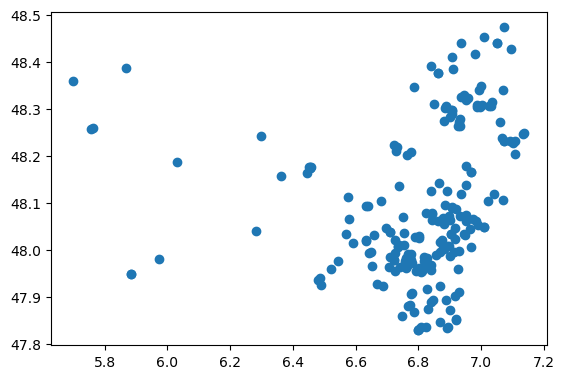

In [49]:
viewpoints.plot()

A lot of points are too close to each other, we don't need all of them as they probably have similar skylines
## Reduce the viewpoints

In [50]:
# convert geoseries to numpy array of shape (N,2)
split_point = lambda point: np.array([point.y, point.x])
v_split_point = np.vectorize(split_point, signature='()->(2)')
np_viewpoints = v_split_point(np.asarray(viewpoints))

In [51]:
# project to Lambert 93
np_viewpoints = project.array_to_lambert93(np_viewpoints)

In [52]:
def get_ids_to_filter(dist_matrix, threshold):
    args = np.argwhere((dist_matrix<threshold) & (dist_matrix!=0))[:,0]
    args = np.unique(args)
    return args

In [53]:
# compute distance between each pair of points
dist_matrix = project.distance_points_points(np_viewpoints, np_viewpoints)
# remove points closer than 5km to another
to_remove = get_ids_to_filter(dist_matrix, 5000)
np_viewpoints = np.delete(np_viewpoints, to_remove, axis=0)
print('Number of viewpoints :', len(np_viewpoints))

Number of viewpoints : 43


In [54]:
# same for indexes
indexes = viewpoints.index.to_frame()['osmid'].to_list()
indexes = np.delete(indexes, to_remove, axis=0)

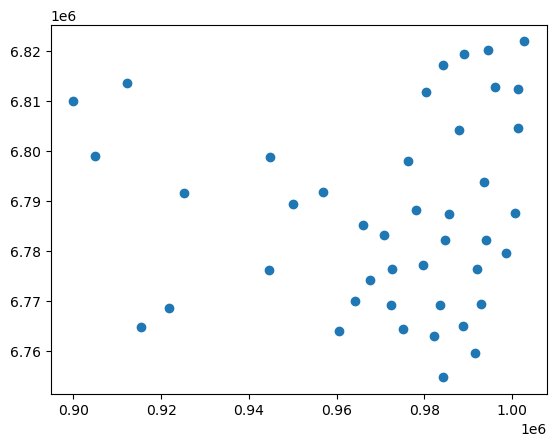

In [55]:
import matplotlib.pyplot as plt
plt.scatter(np_viewpoints[:,0], np_viewpoints[:,1])

## Download terrain data

In [56]:
terrain_data = "./data/MNS/OSM/"
horizon_data = "./data/horizon/OSM/"
place_name = place.split(',')[0]
n=5
margin_distance=50

In [57]:
bounds = viewpoints.total_bounds.tolist()
bounds[:2] = load.bounds_from_distance(bounds[1], bounds[0], margin_distance)[:2]
bounds[2:] = load.bounds_from_distance(bounds[3], bounds[2], margin_distance)[2:]
bounds

[5.364671204160852, 47.6042950499775, 7.476612525048835, 48.6993102500225]

In [58]:
if not os.path.exists(terrain_data+place_name+'.xyz'):
    load.download_from_eio(terrain_data, place_name, bounds=bounds)
pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')

make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
cp SRTM3.vrt SRTM3.8ea689c02d3245b6879f021de09a4f05.vrt
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 5.364671204160852 48.6993102500225 7.476612525048835 47.6042950499775 SRTM3.8ea689c02d3245b6879f021de09a4f05.vrt /media/nicod/Documents/D4G/pyronear/lidar/data/MNS/OSM/Vosges.tiff


rm -f SRTM3.8ea689c02d3245b6879f021de09a4f05.vrt
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
File ./data/MNS/OSM/Vosges.xyz ready.


In [59]:
o3d.visualization.draw_geometries([pc])

## Extract skyline for each viewpoint

In [60]:
def crop_pc(pc, view_point, distance=50_000):
    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(view_point[0]-distance, view_point[1]-distance, -1000), 
                                            max_bound=(view_point[0]+distance, view_point[1]+distance, 5000))
    return pc.crop(bbox)

In [61]:
def get_viewpoint_altitude(pc, view_point):
    terrain_points = np.asarray(pc.points)
    closest = project.closest_point(terrain_points[:,0:2], view_point[:2])
    view_point = np.append(view_point,  terrain_points[closest][2] + 3) # add 3m to not be at ground level
    return view_point

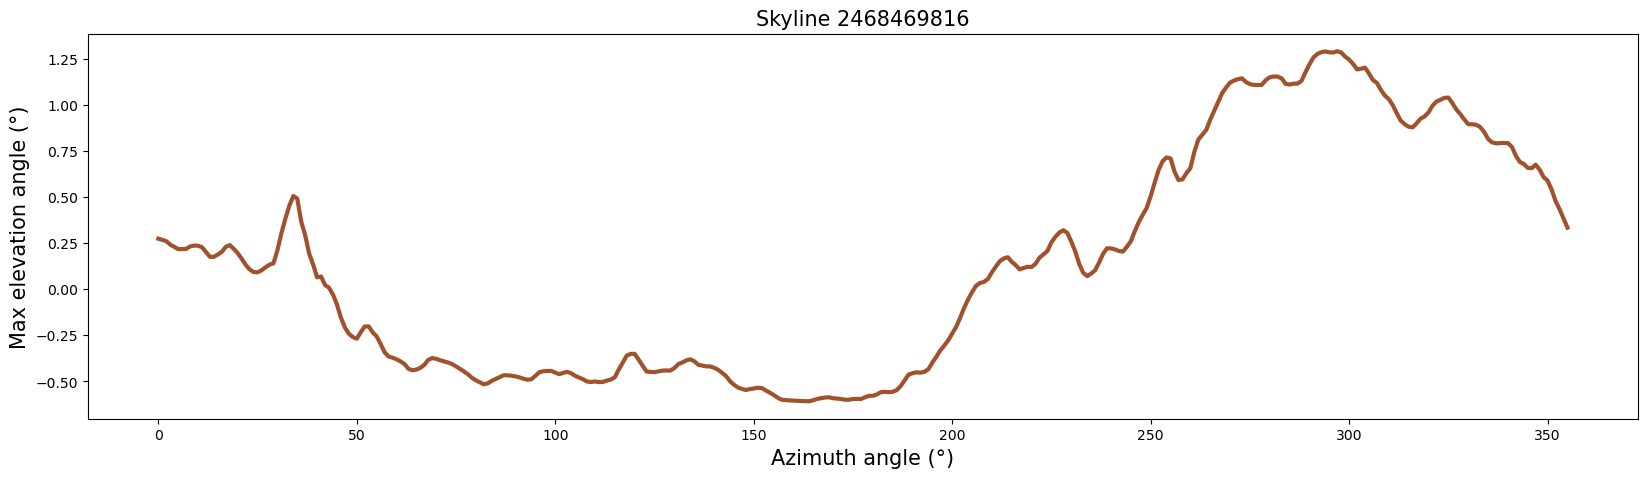

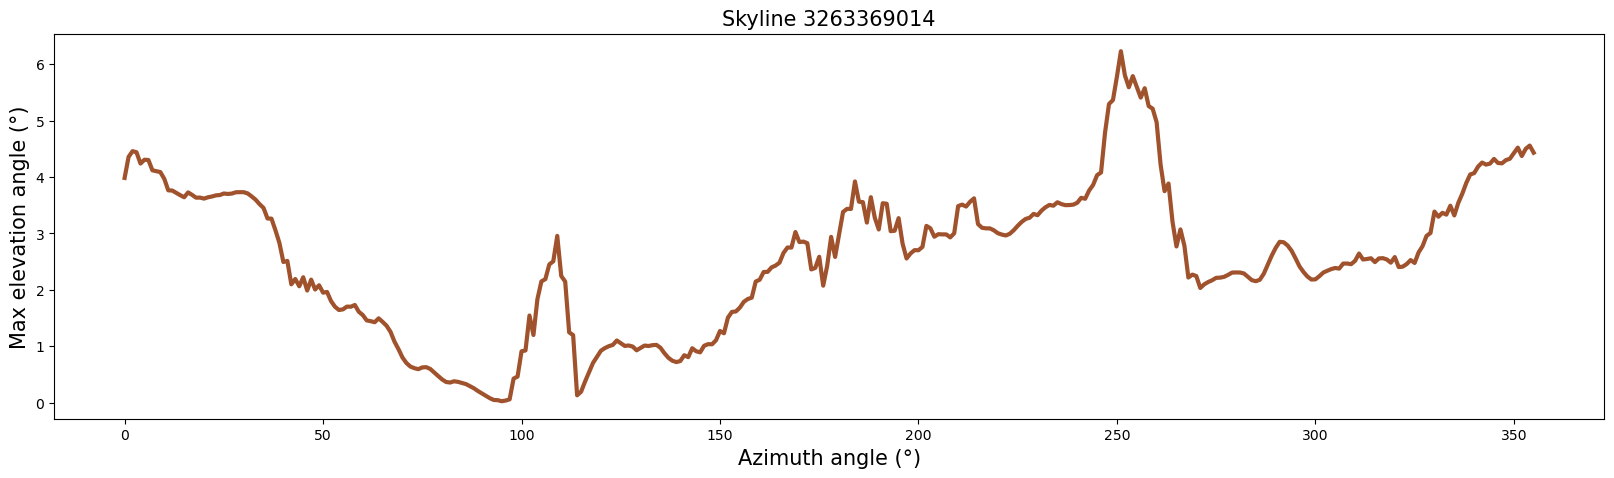

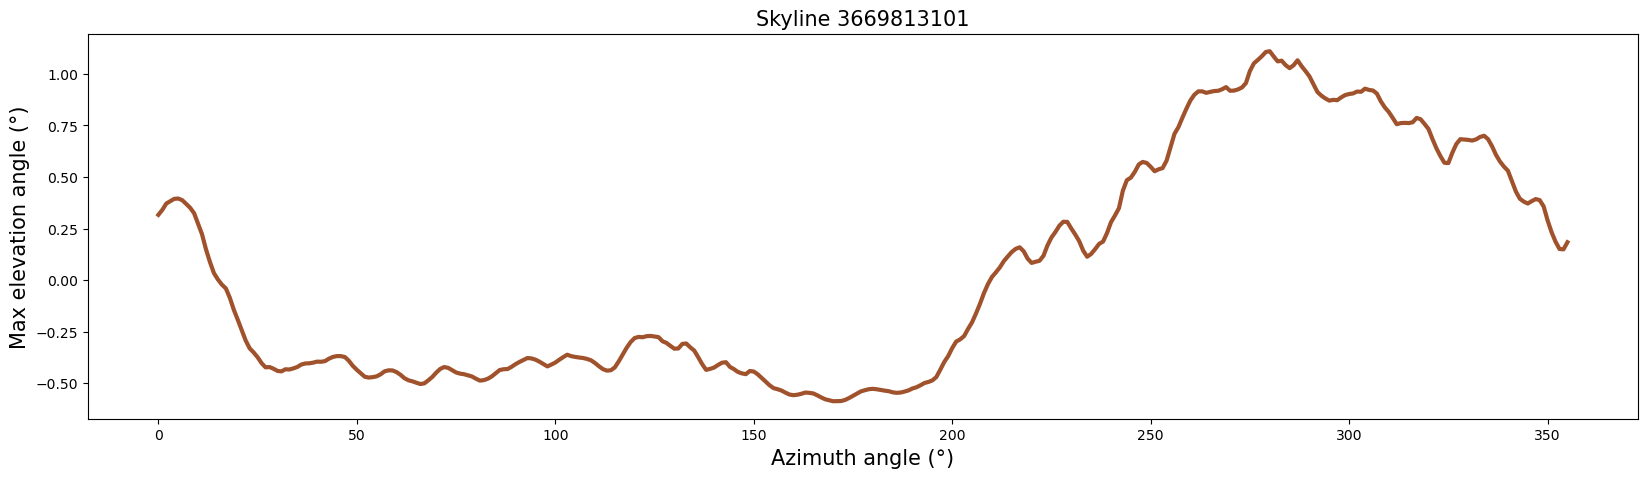

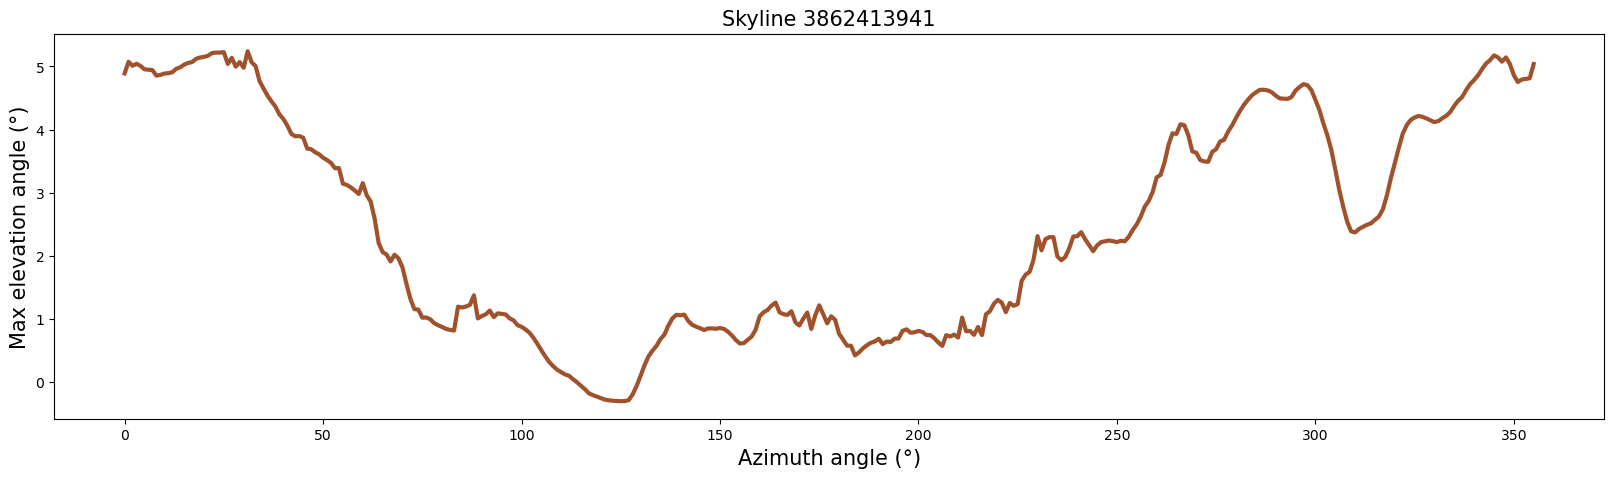

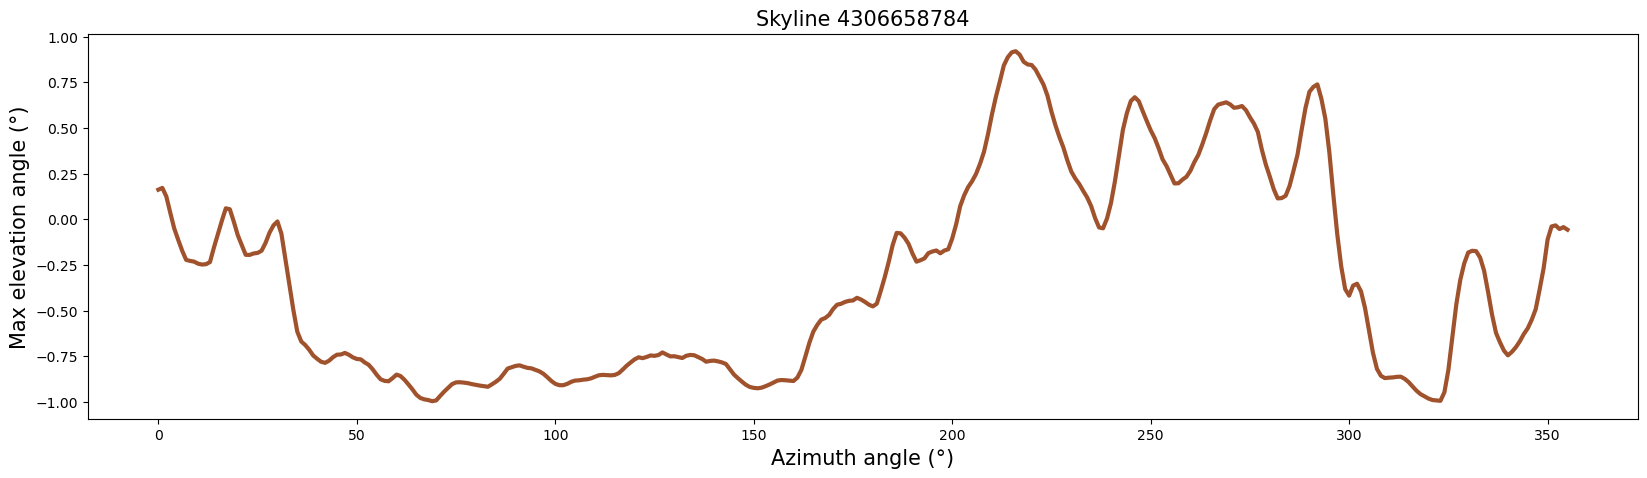

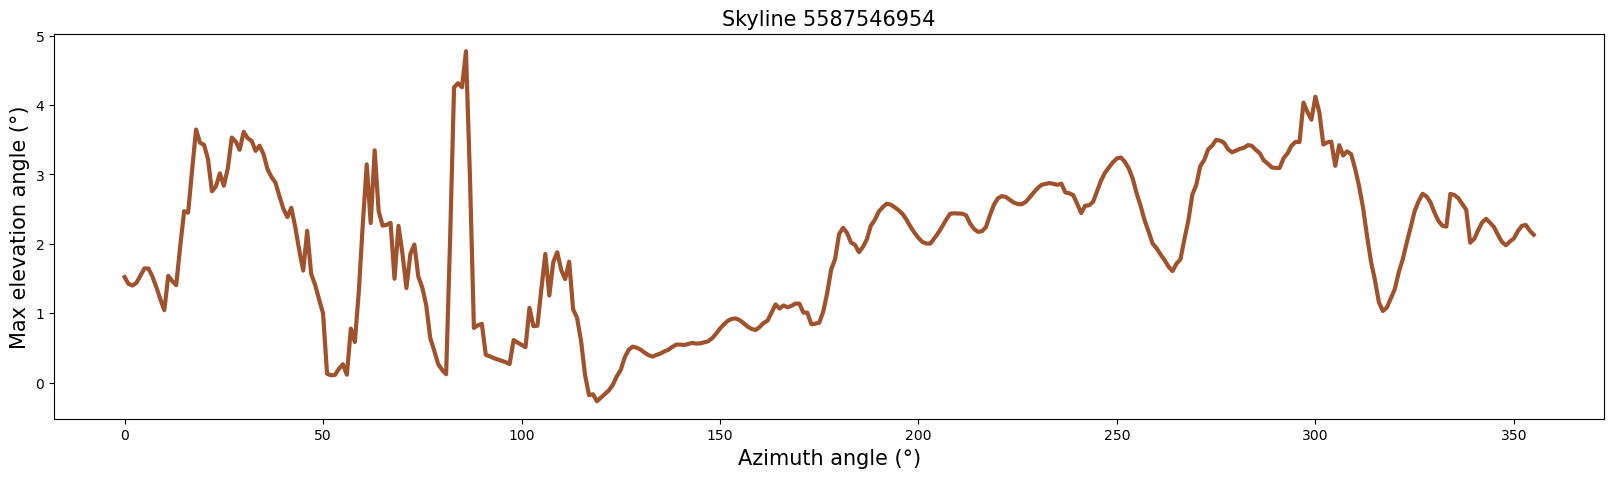

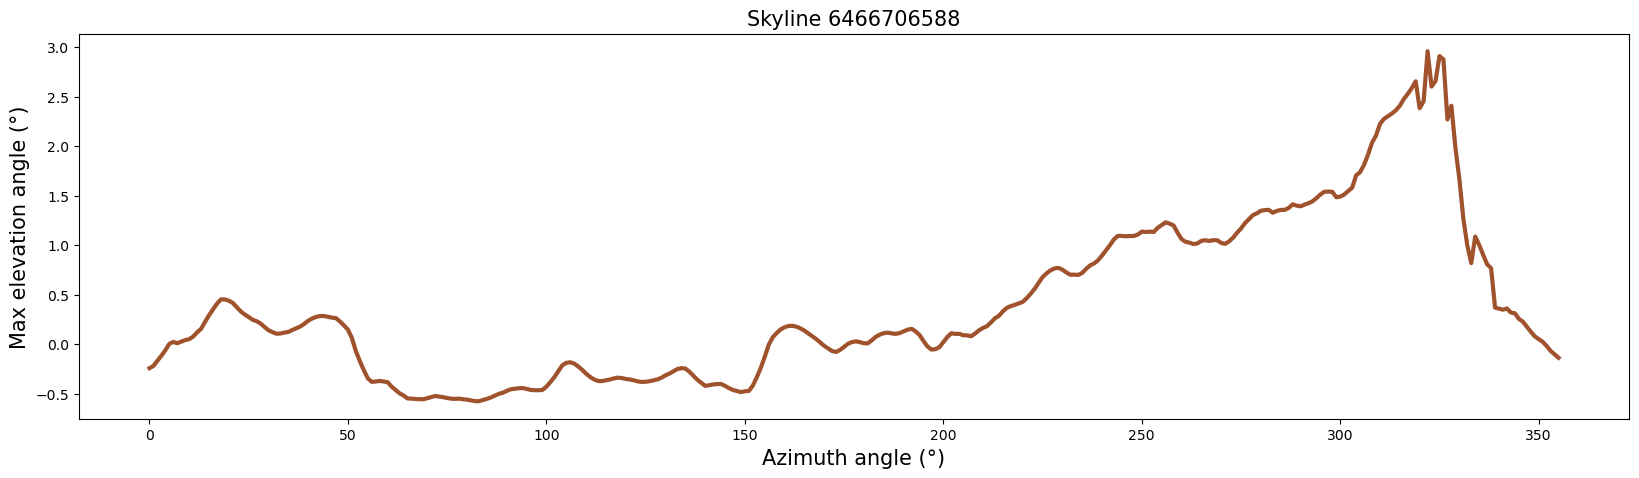

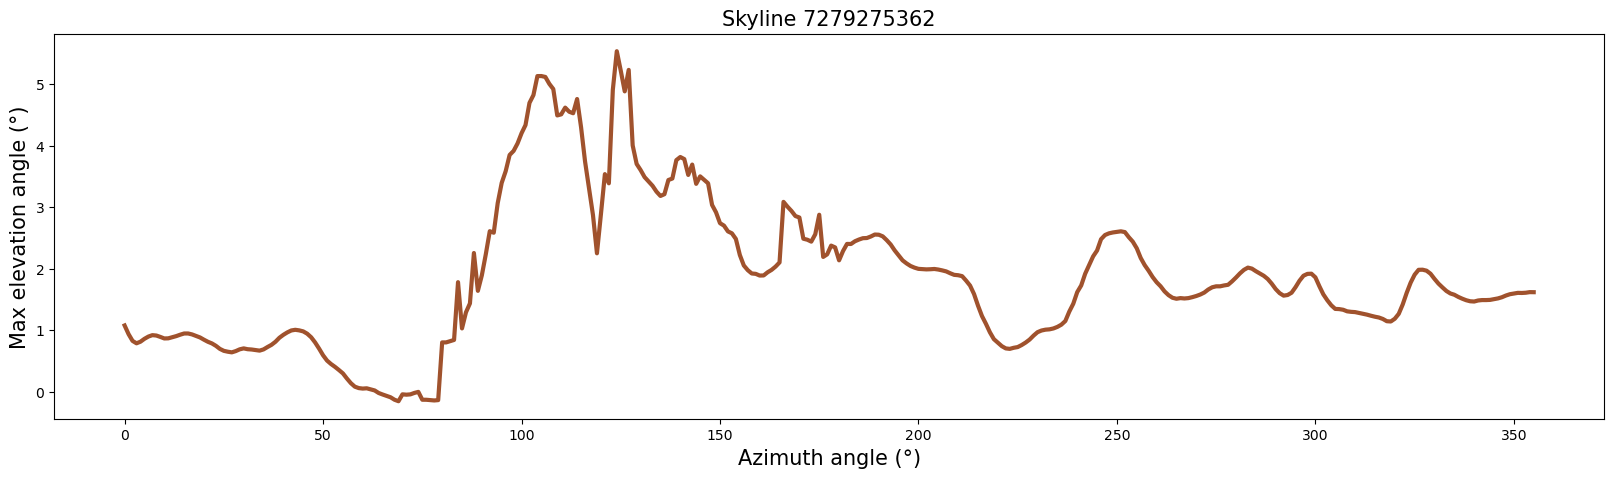

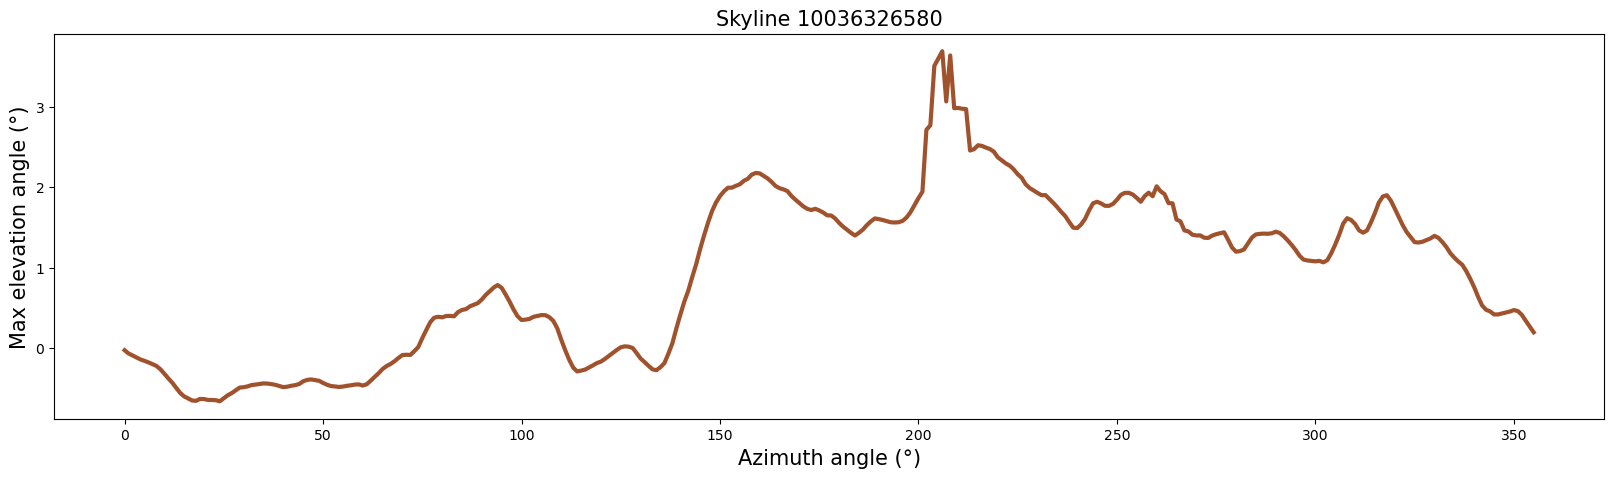

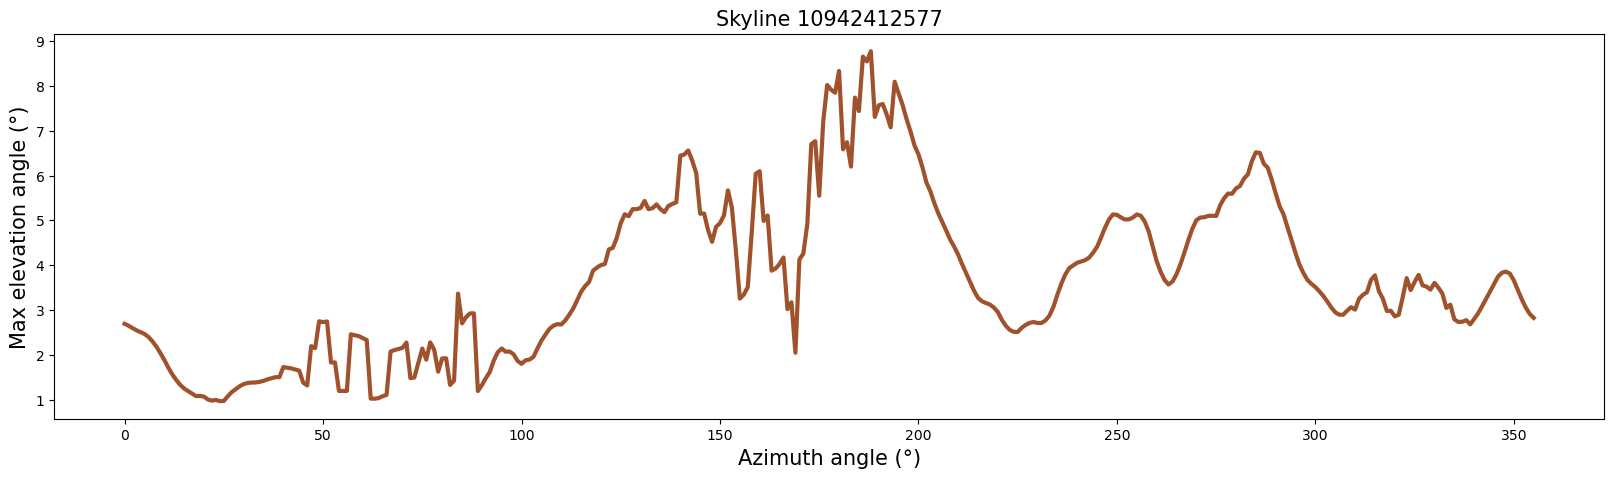

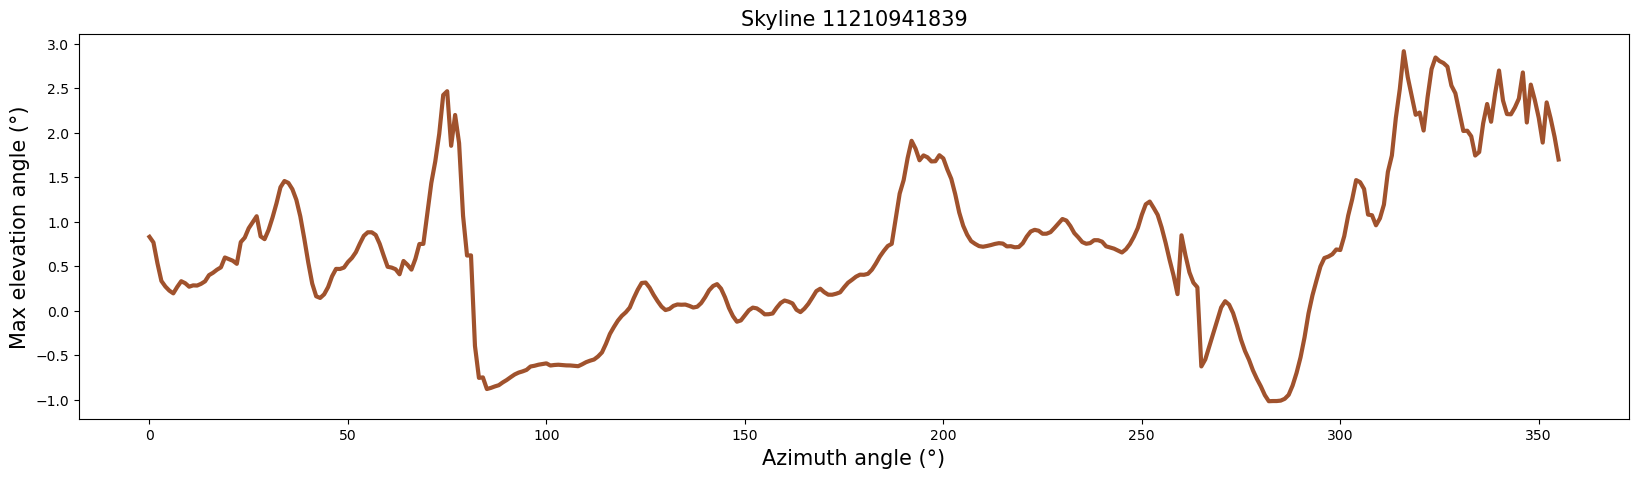

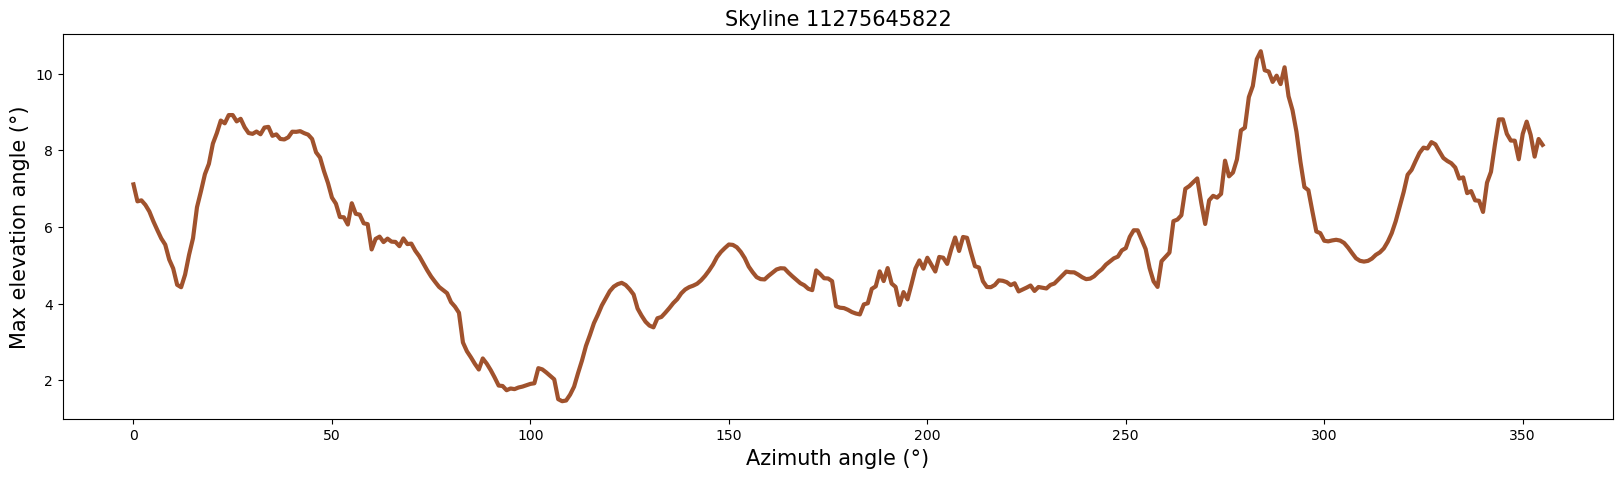

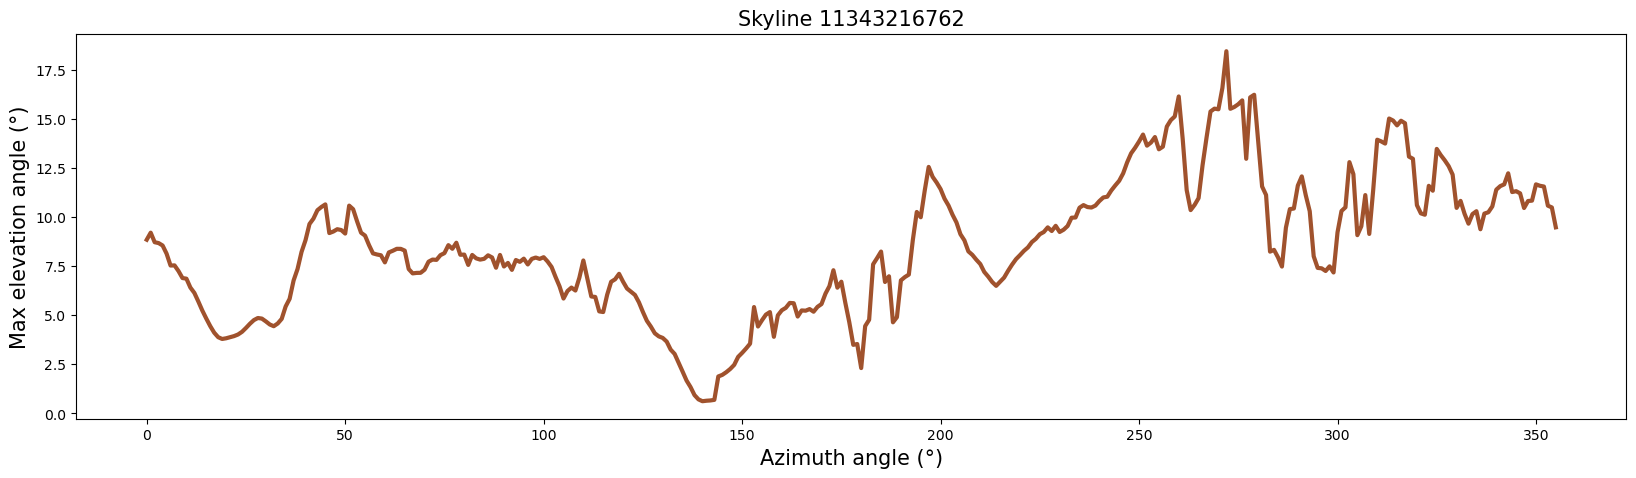

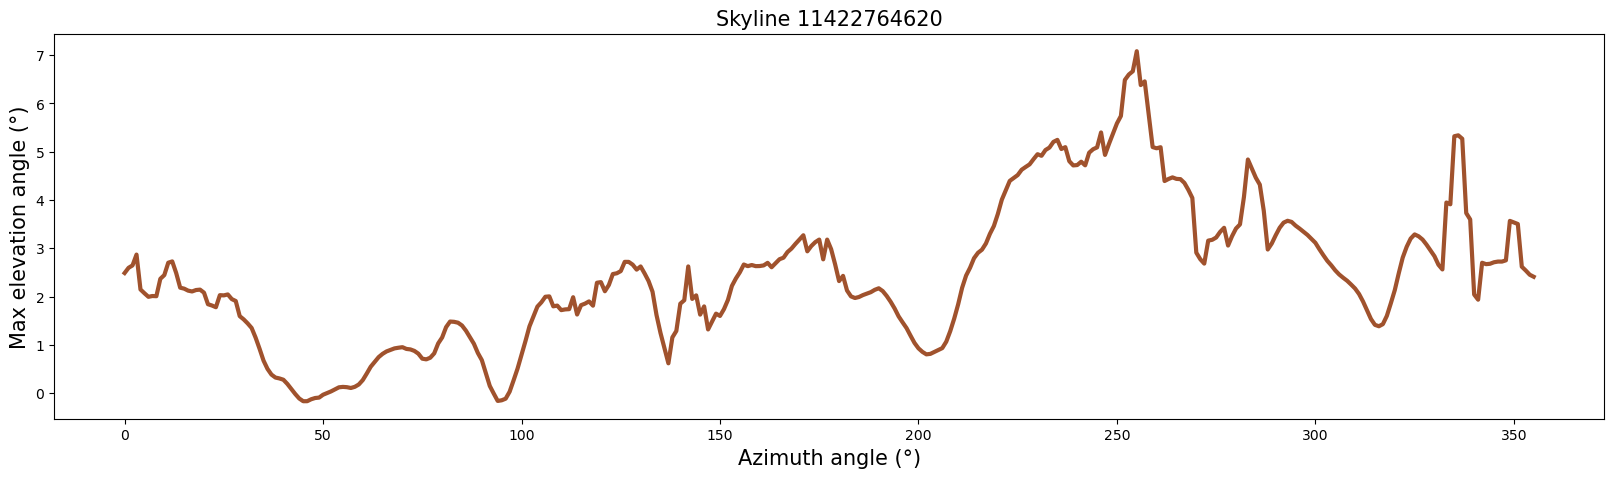

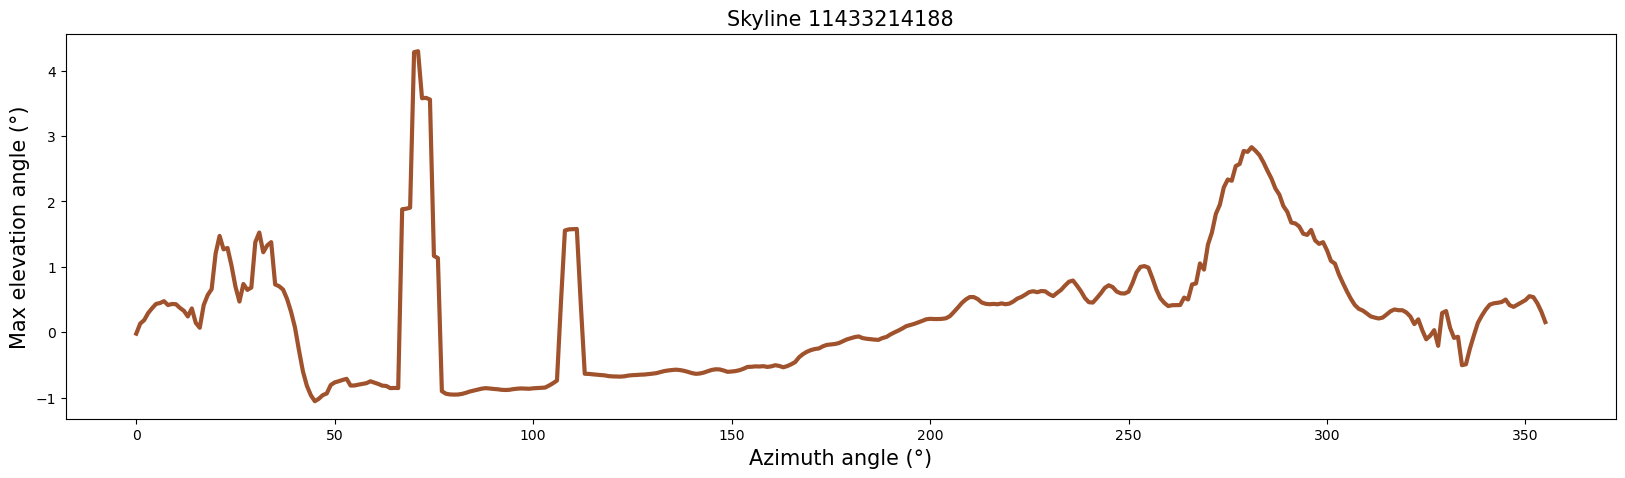

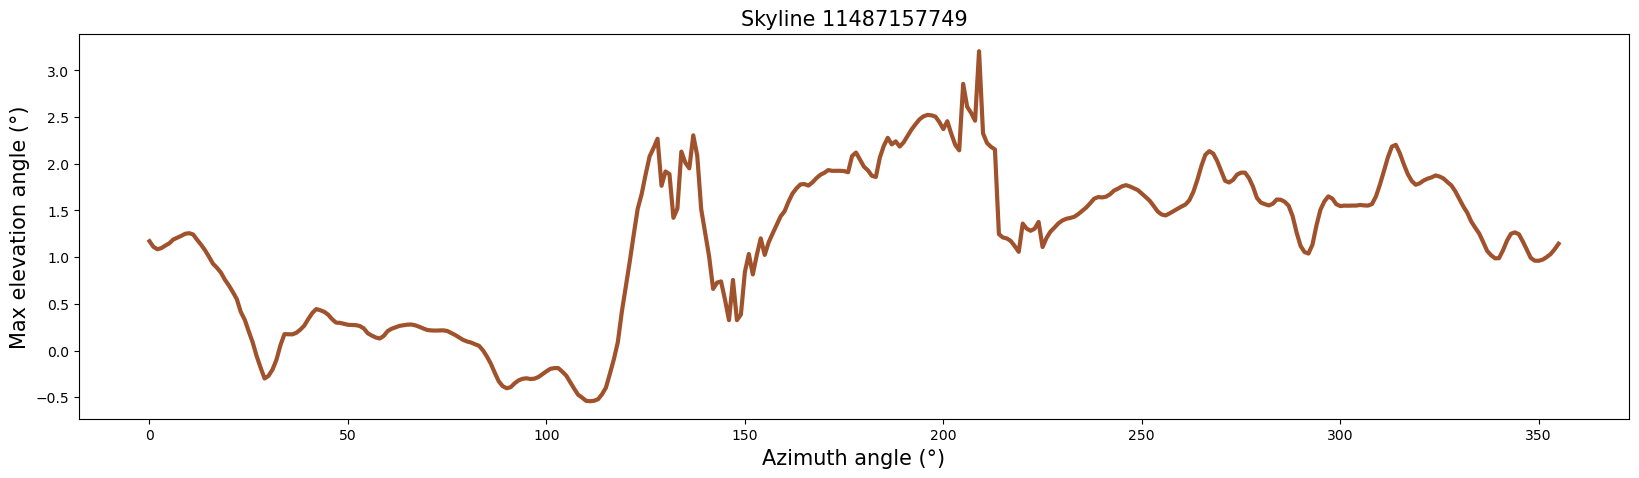

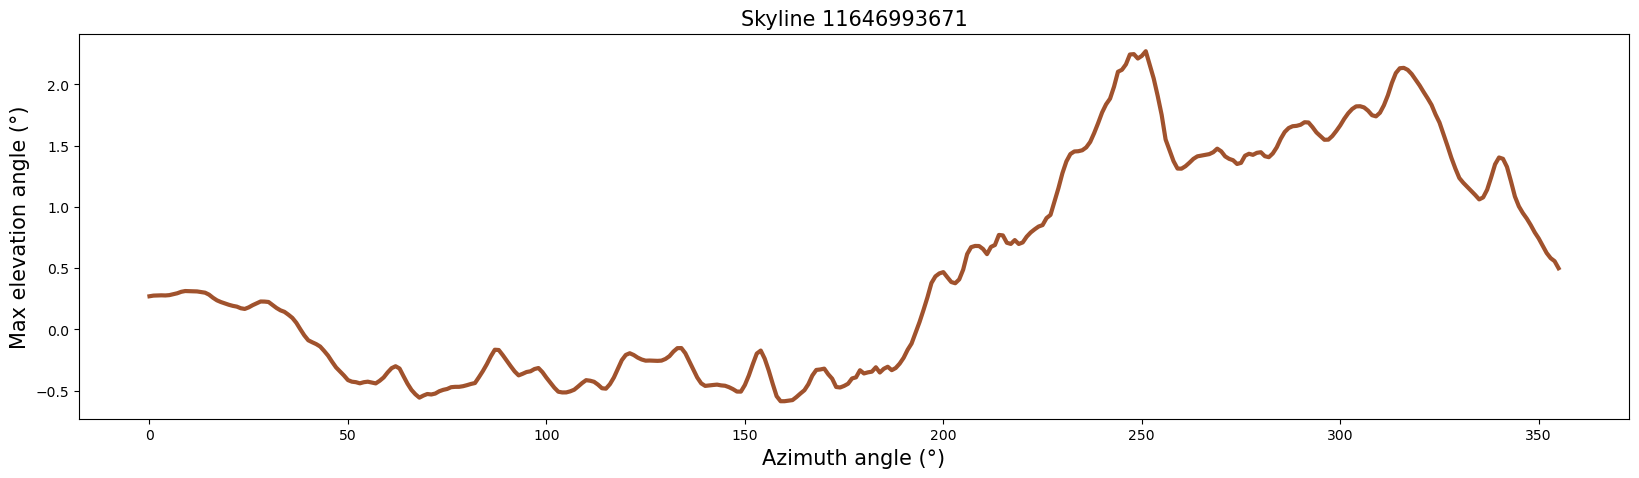

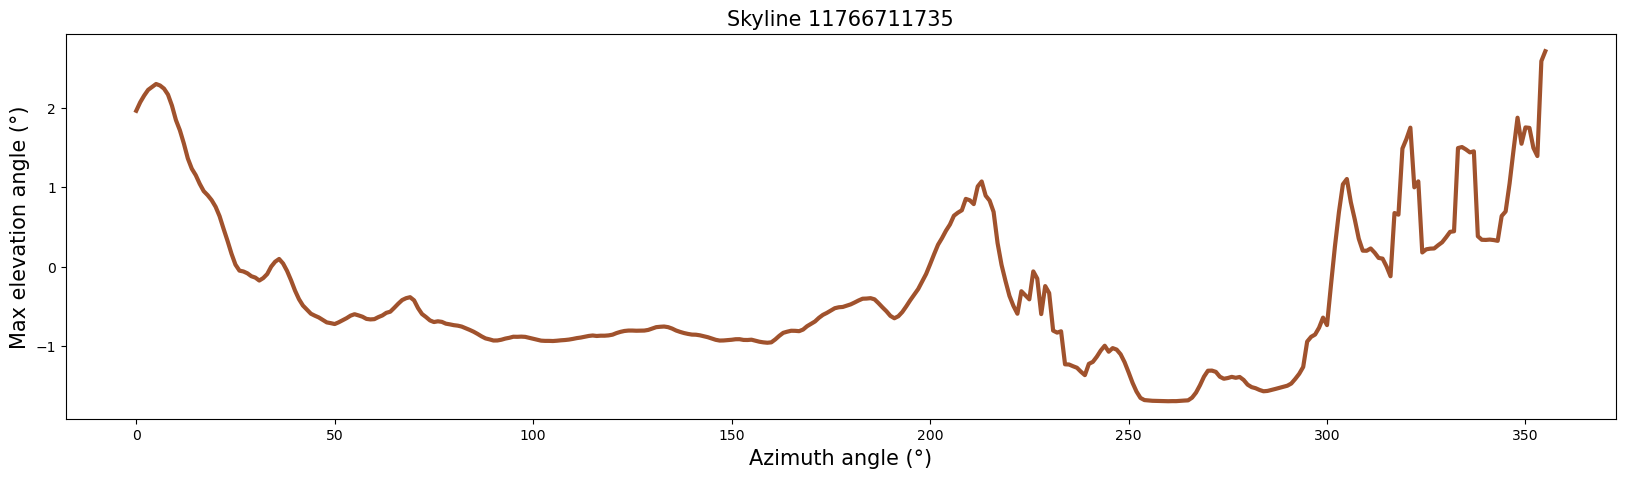

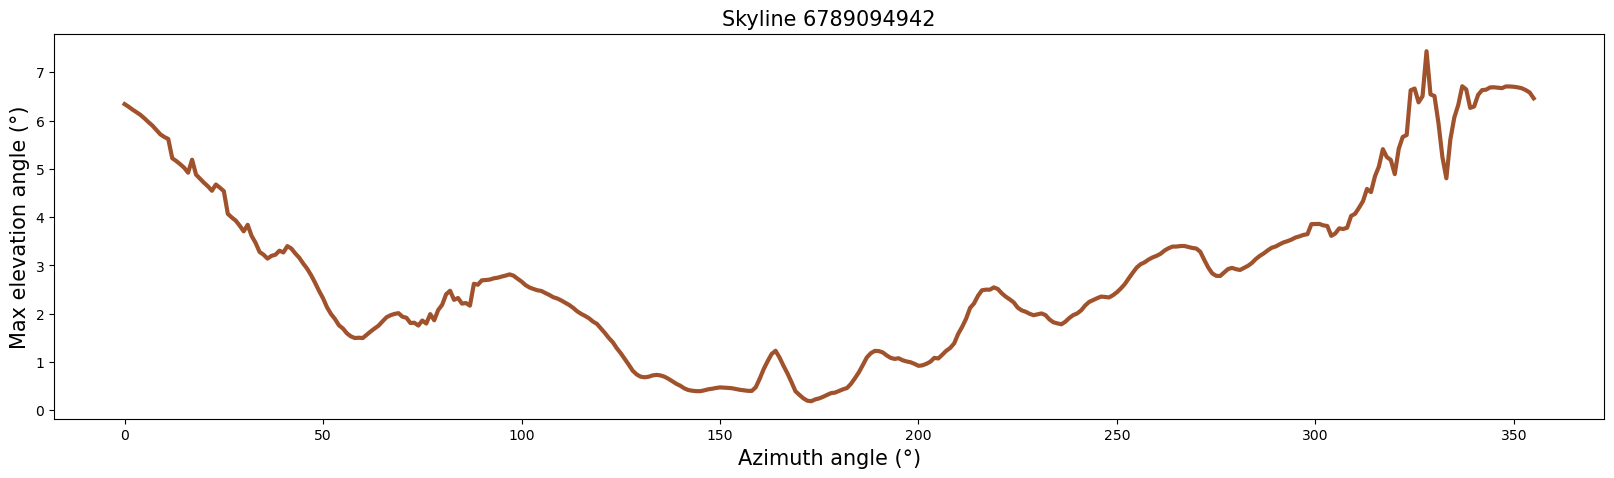

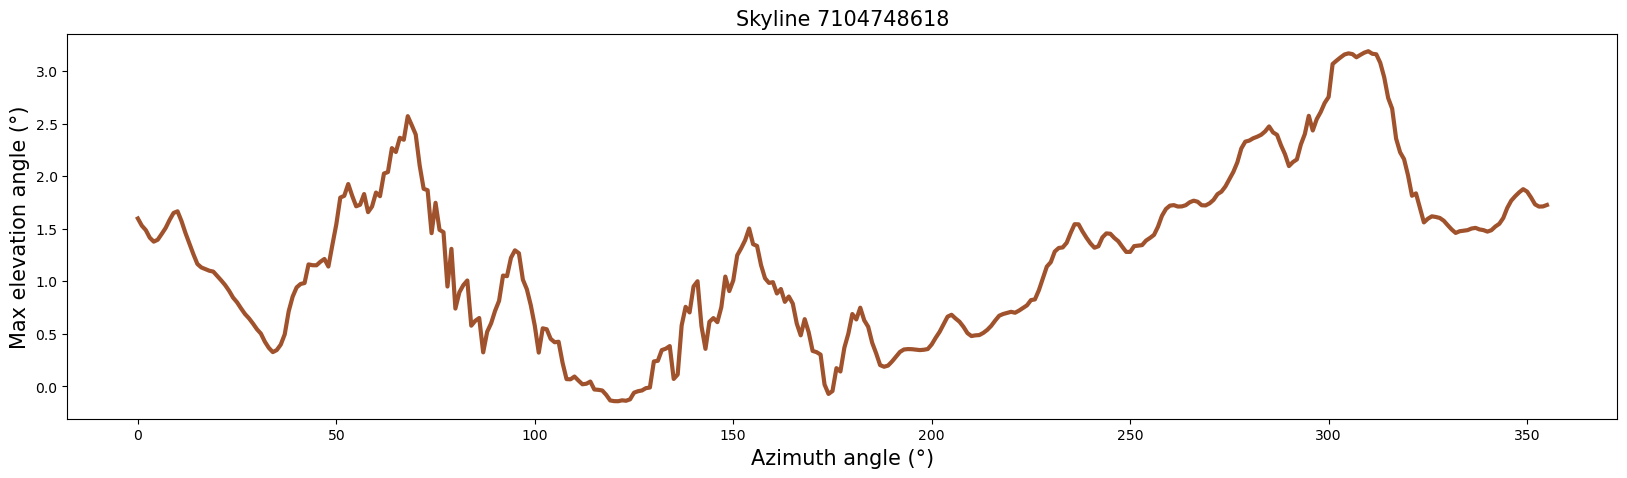

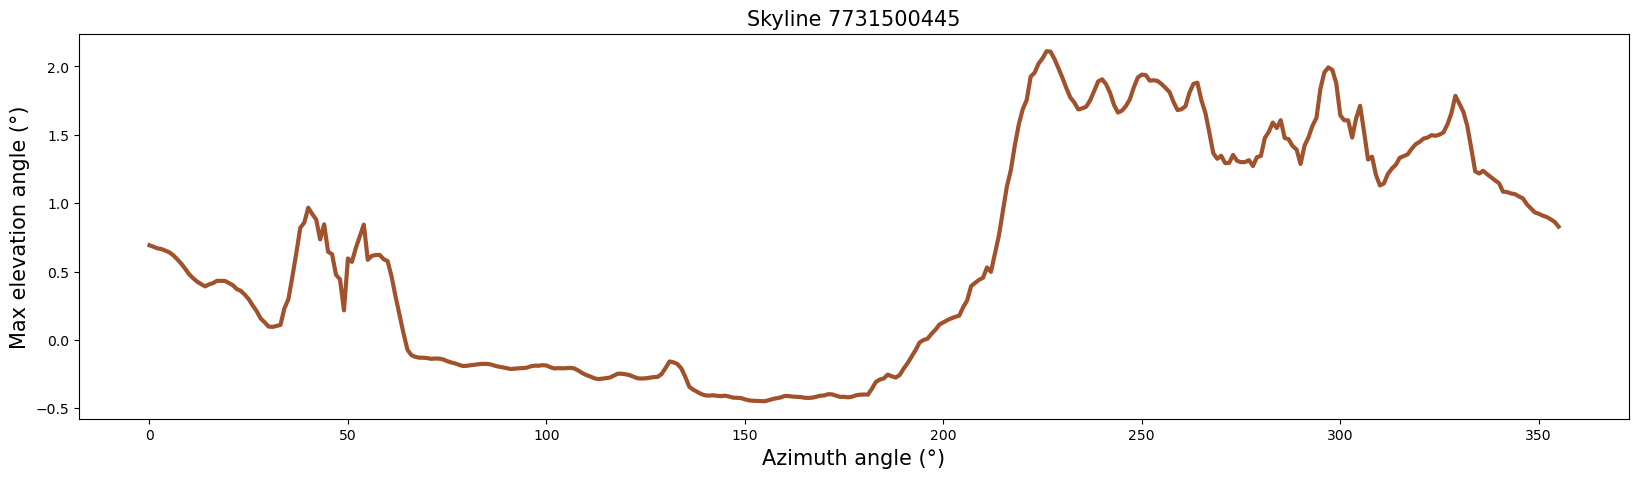

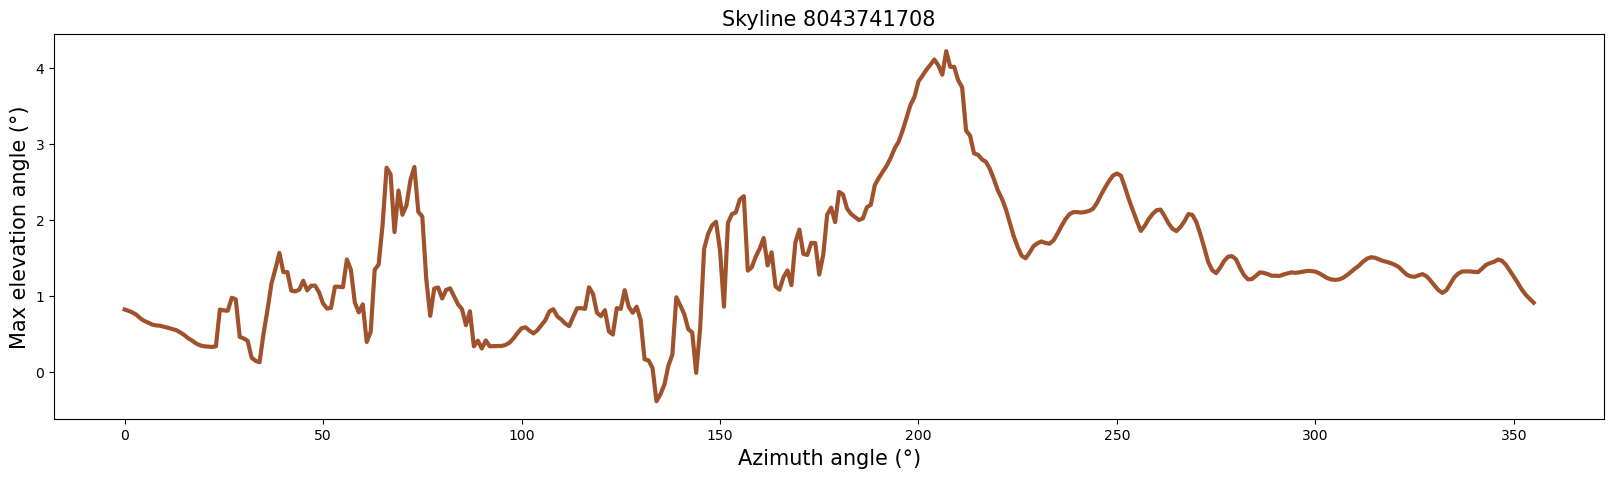

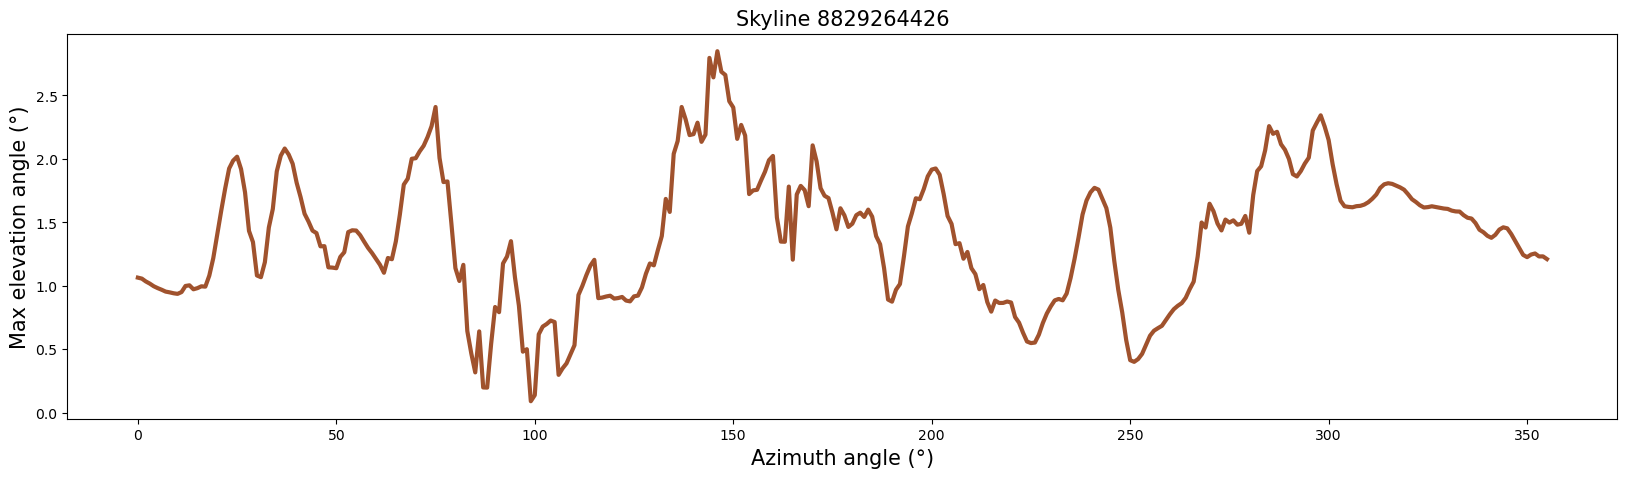

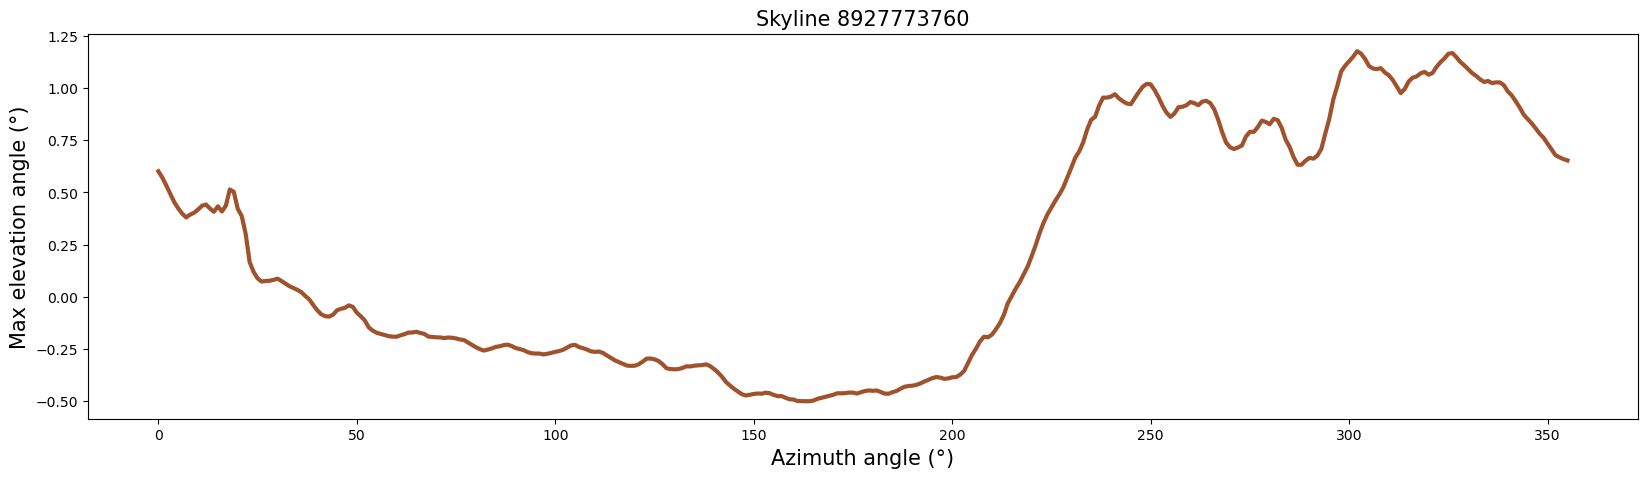

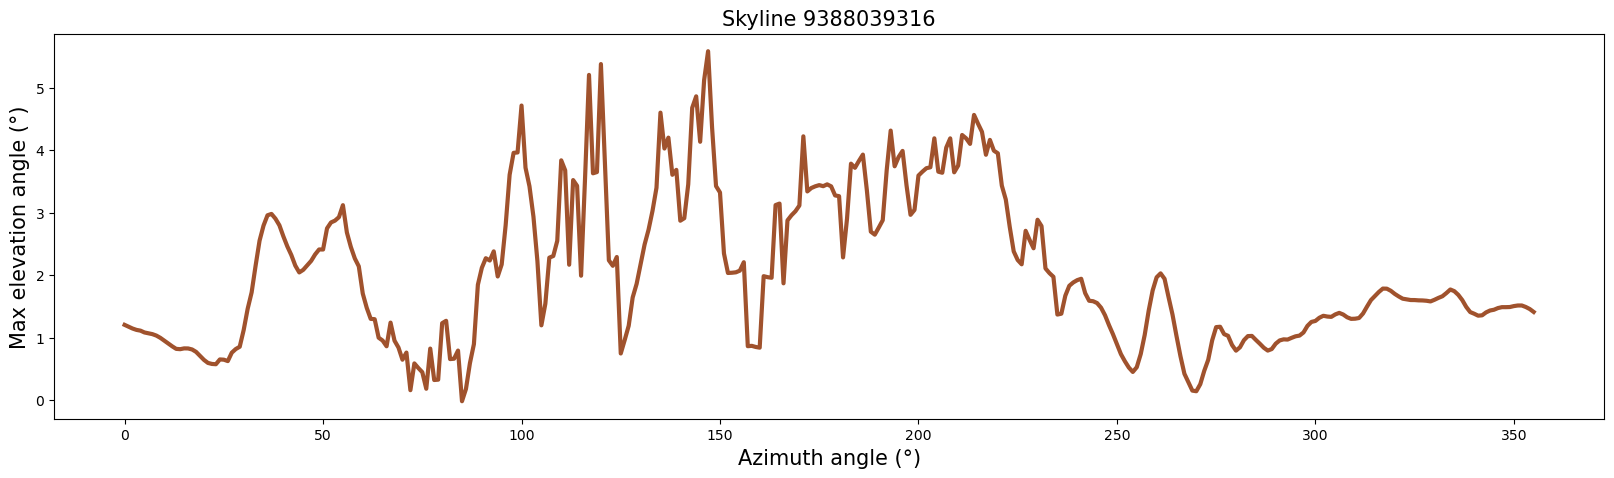

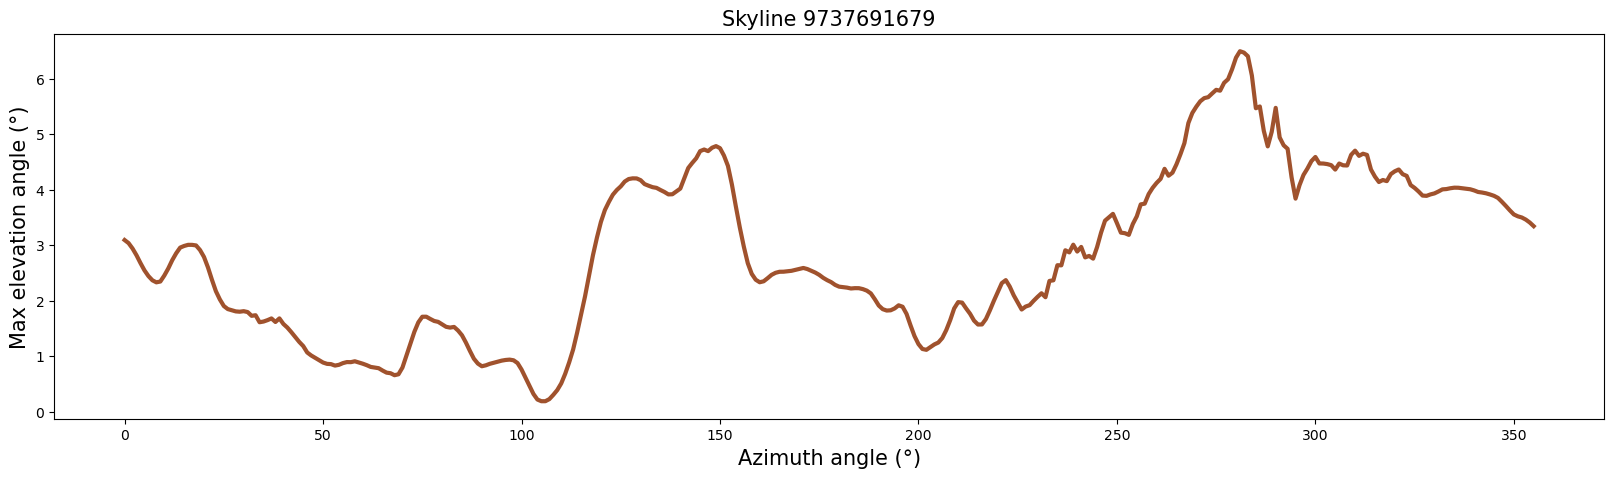

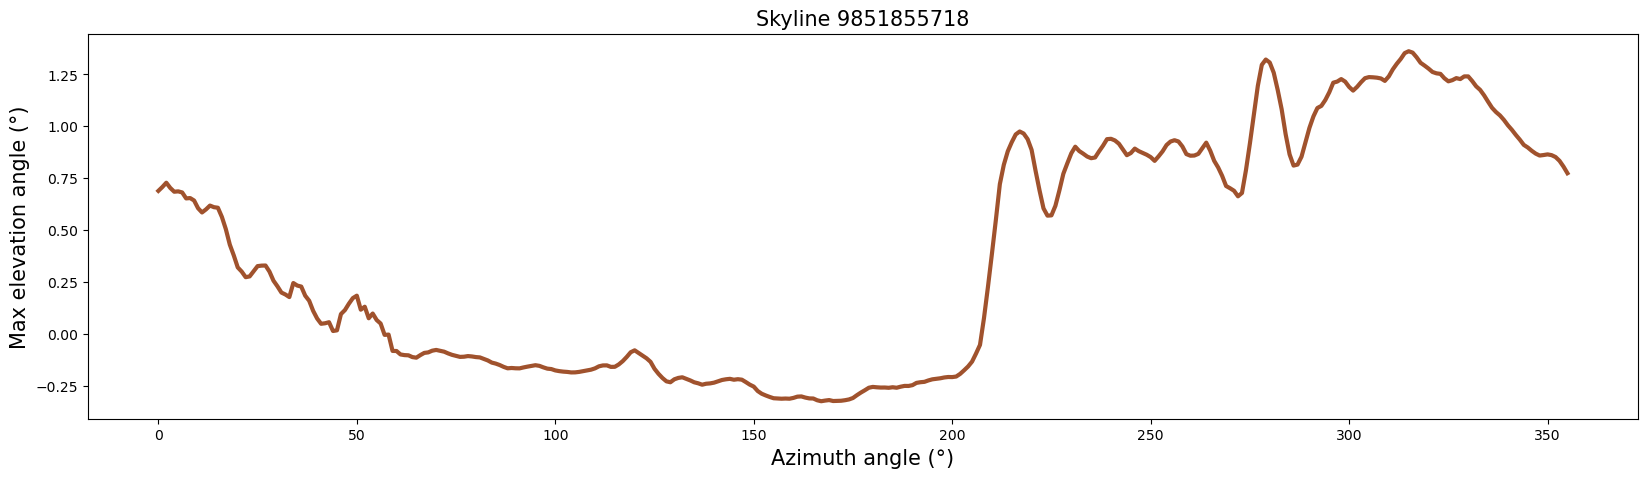

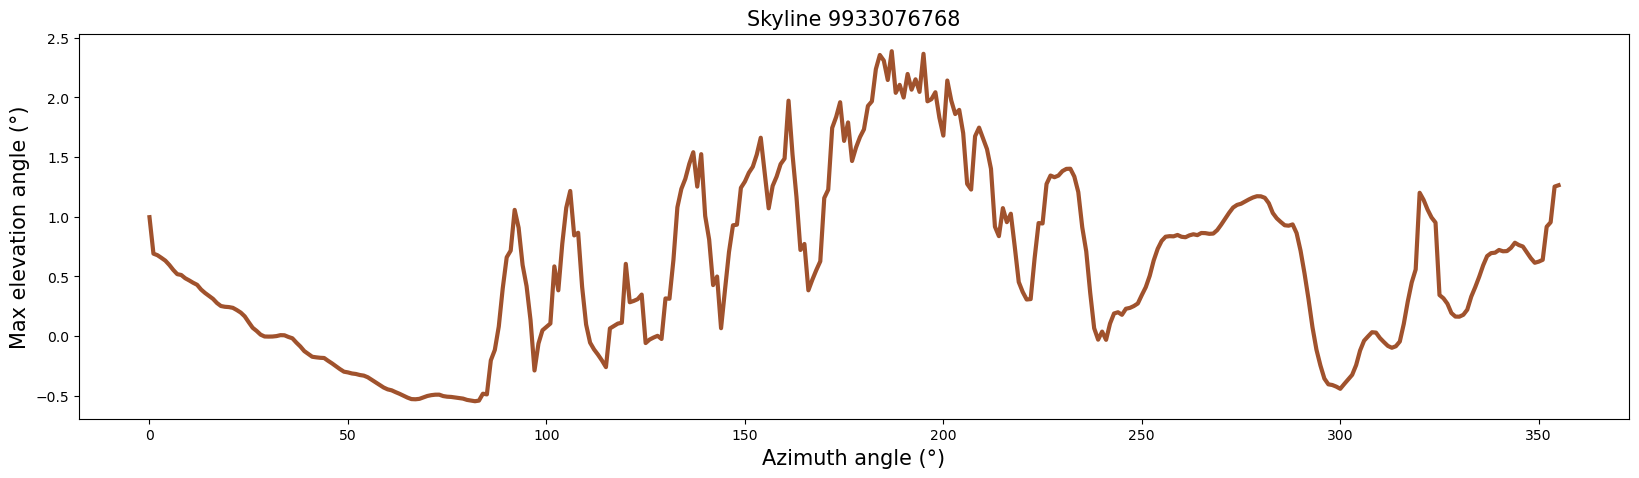

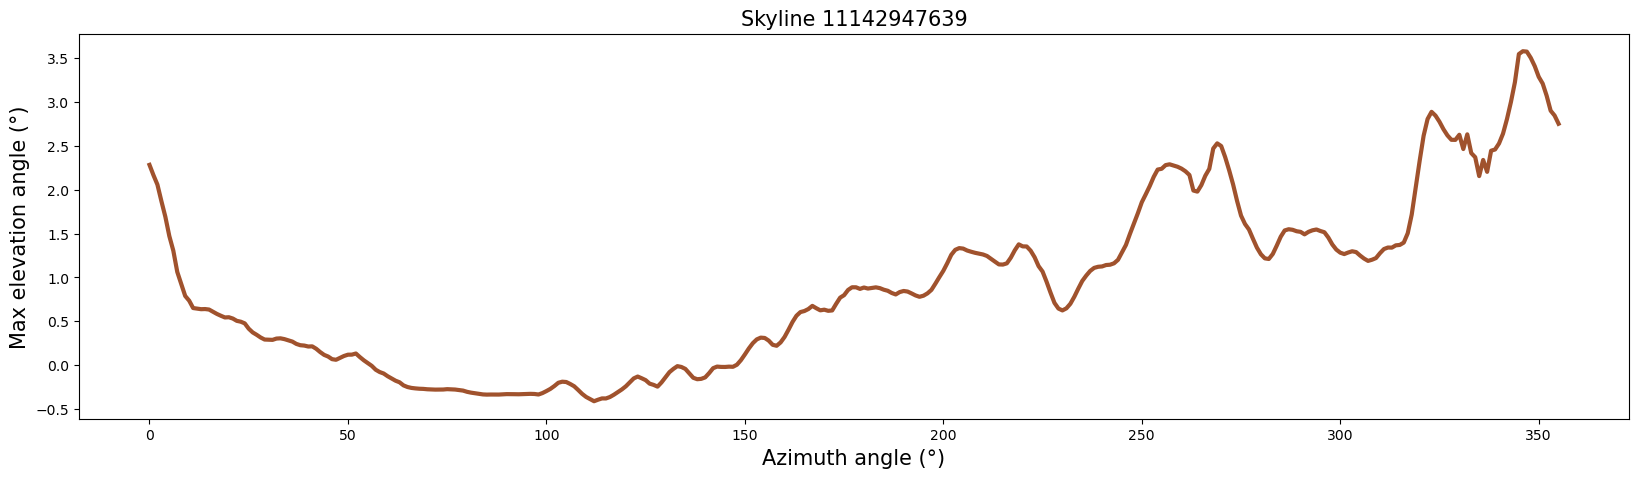

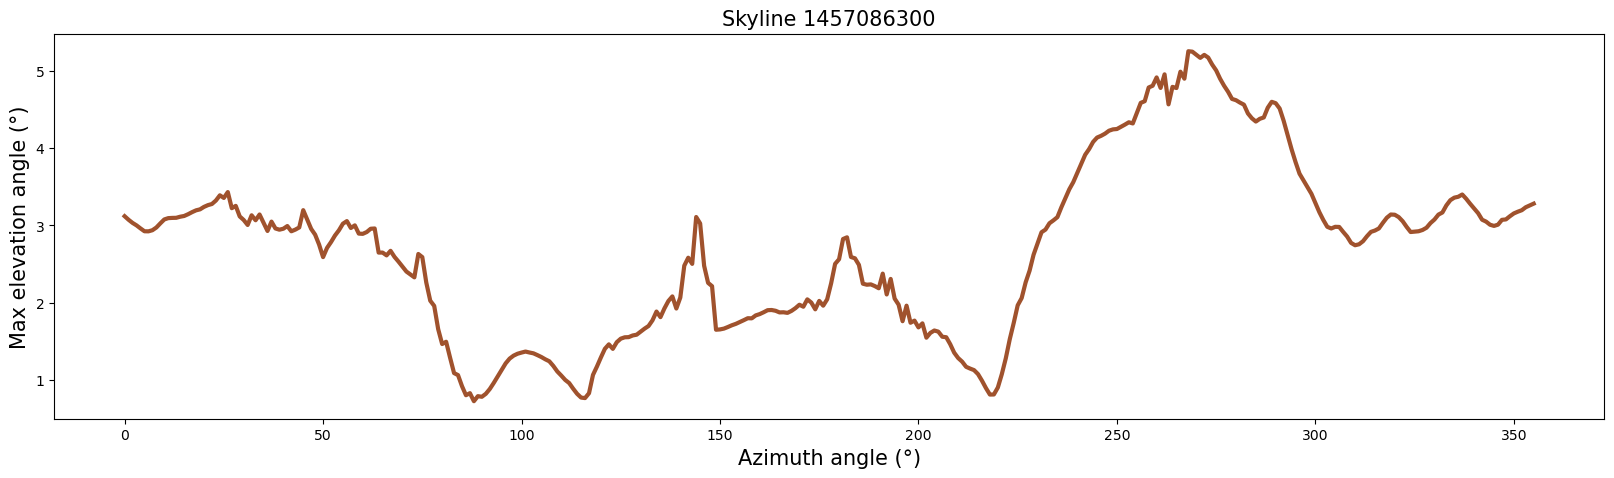

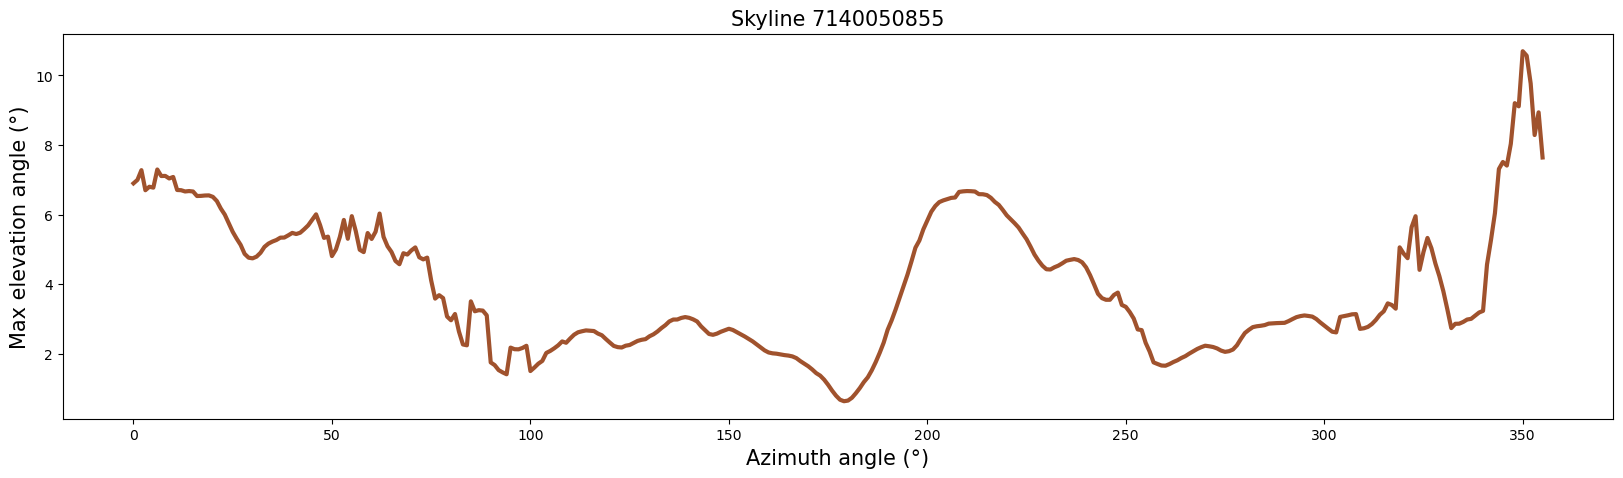

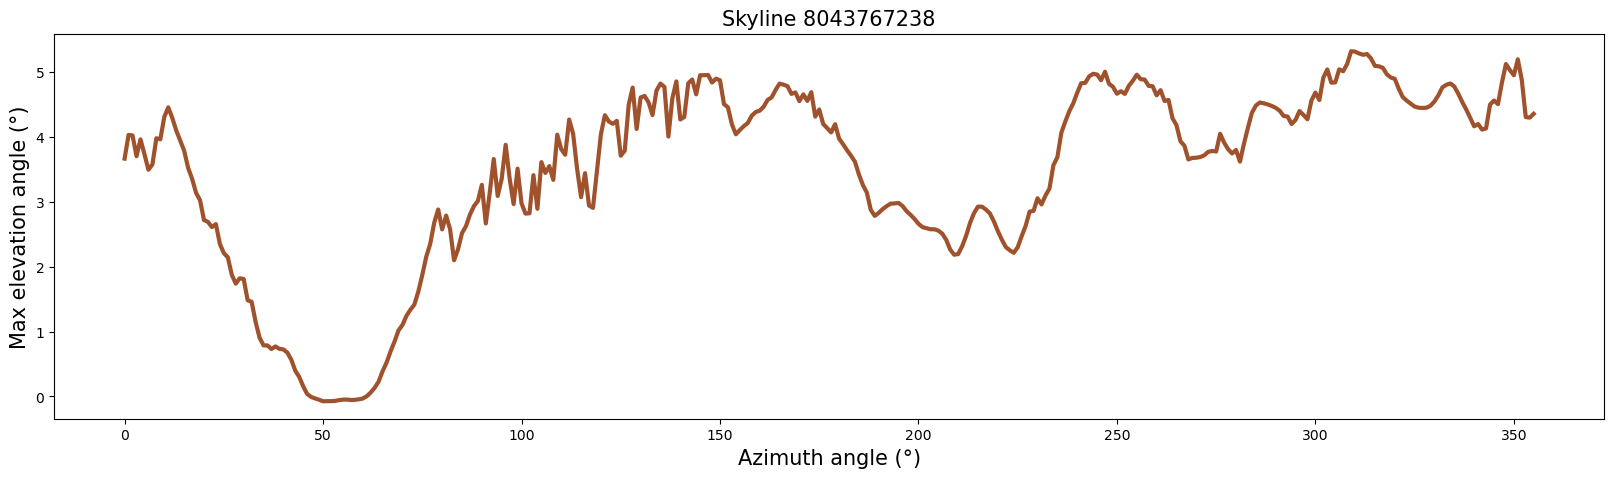

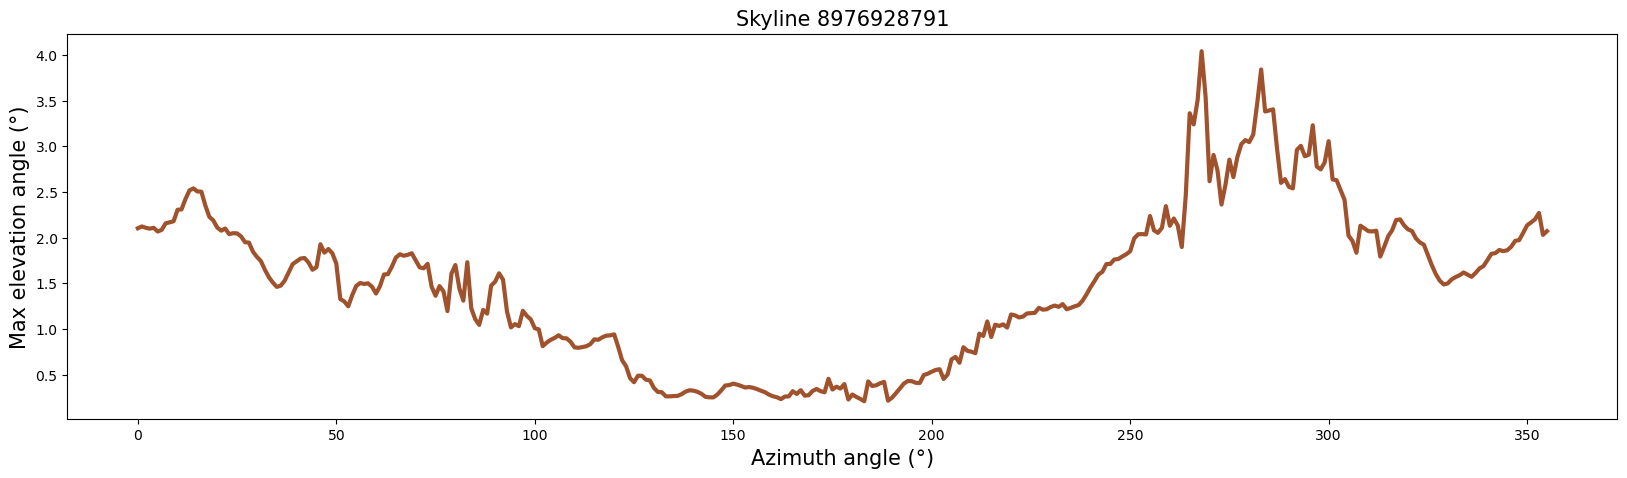

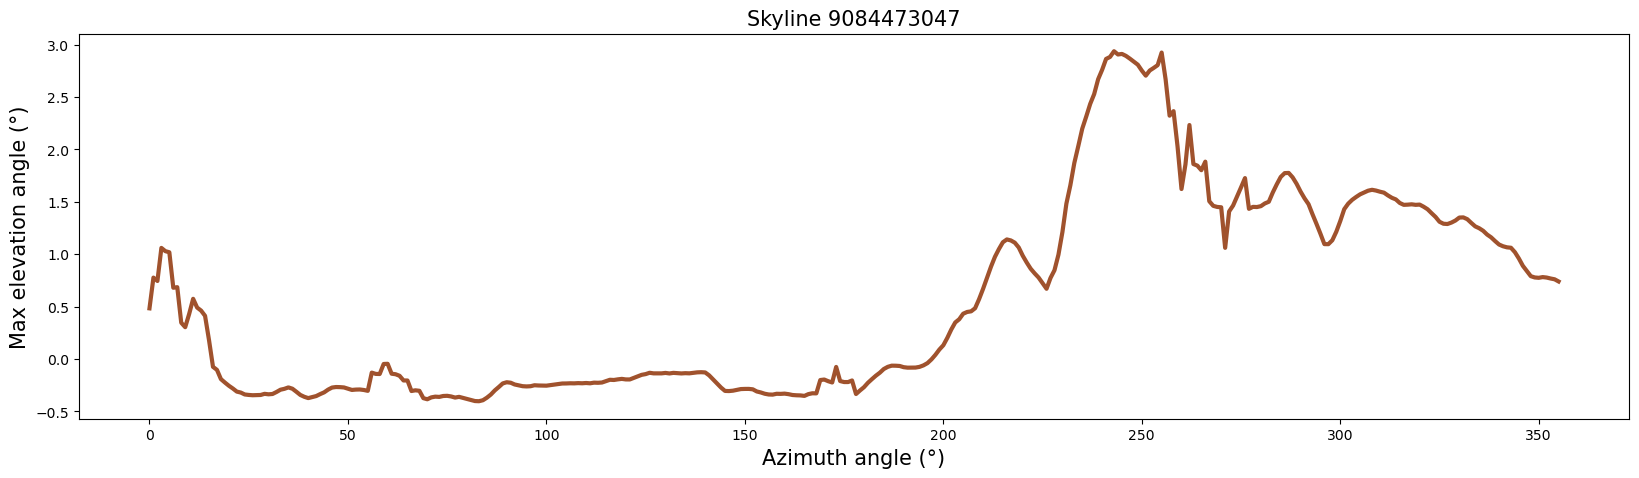

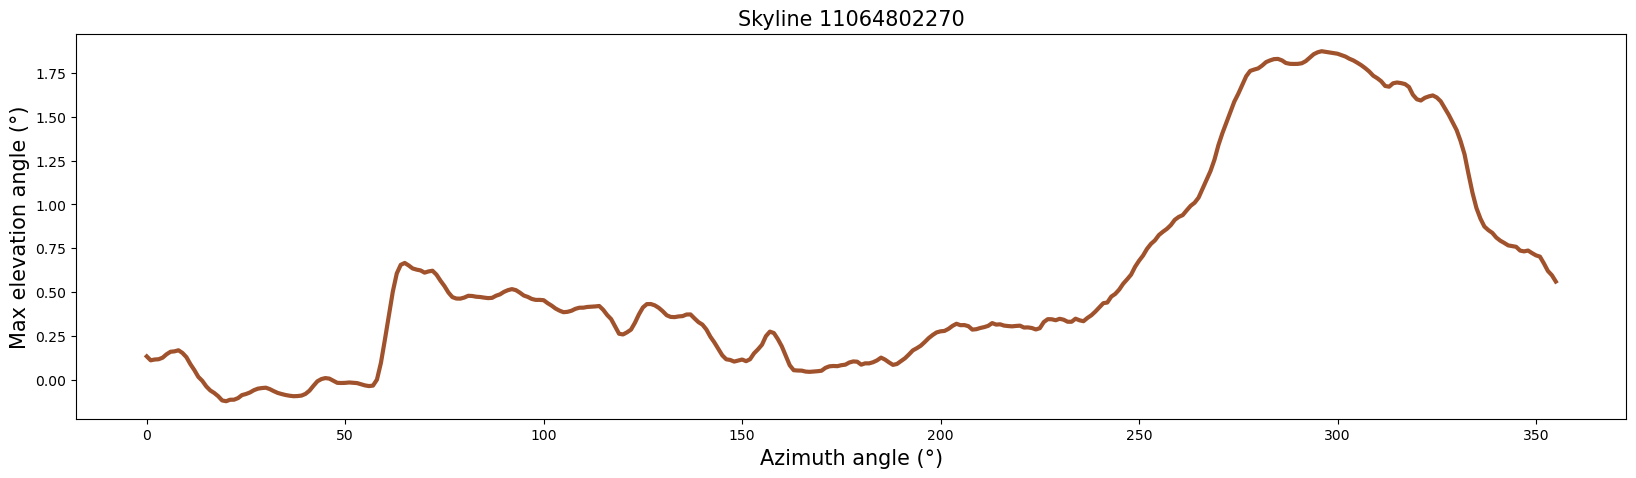

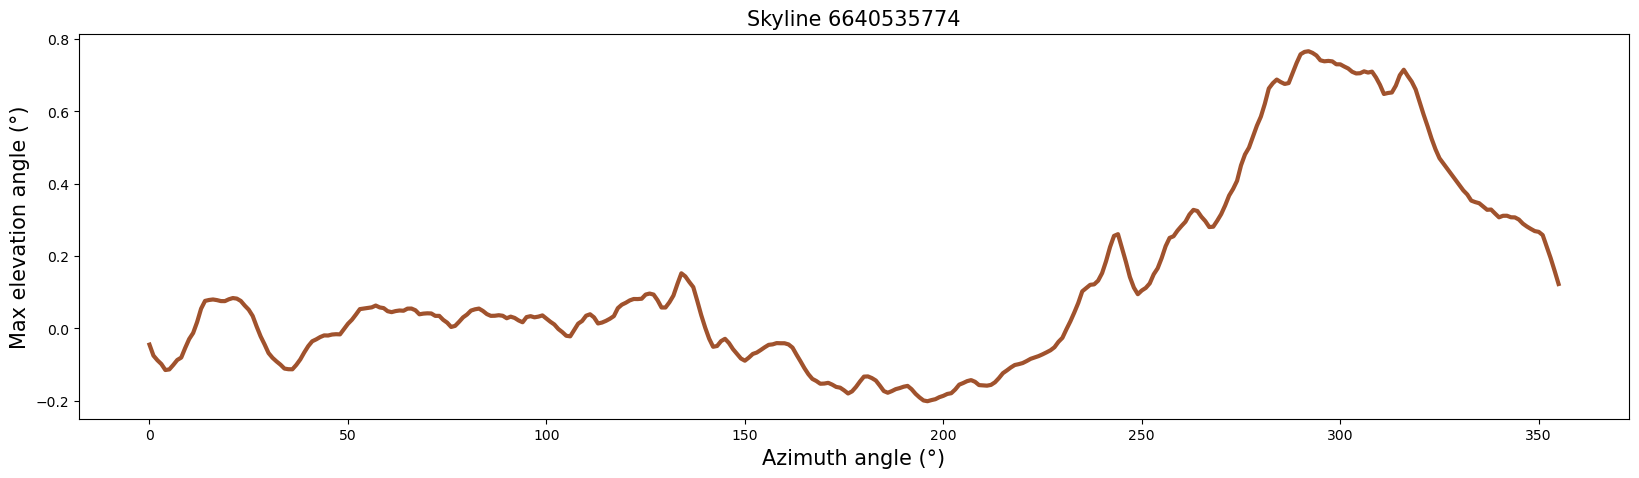

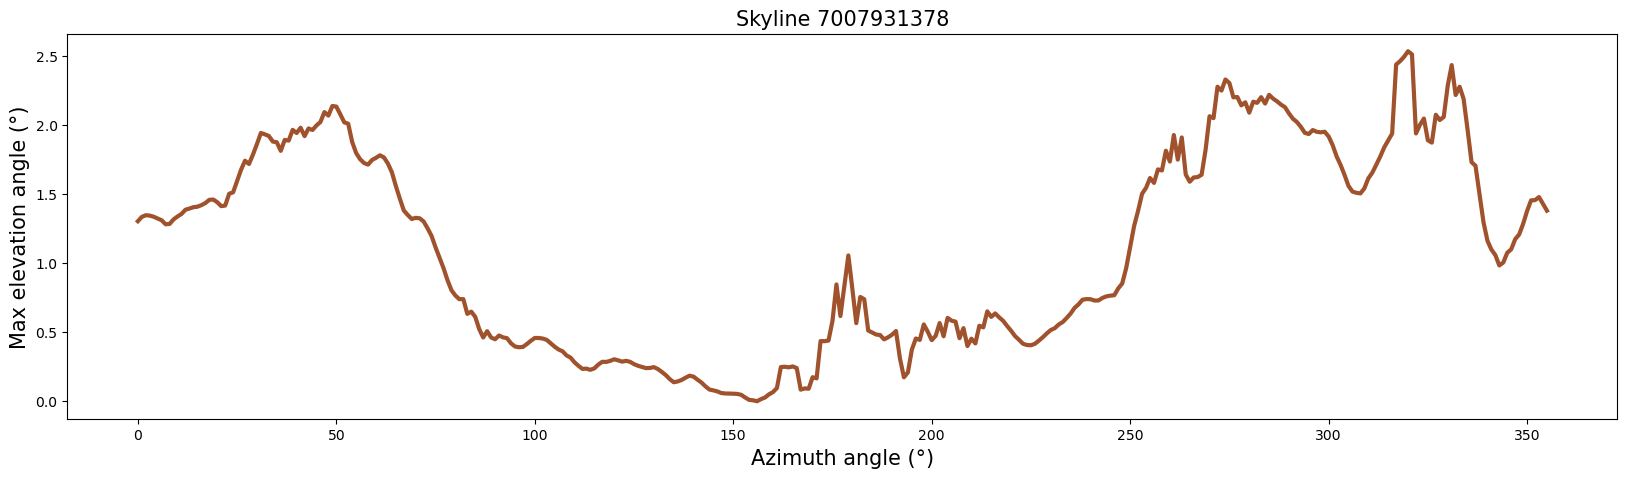

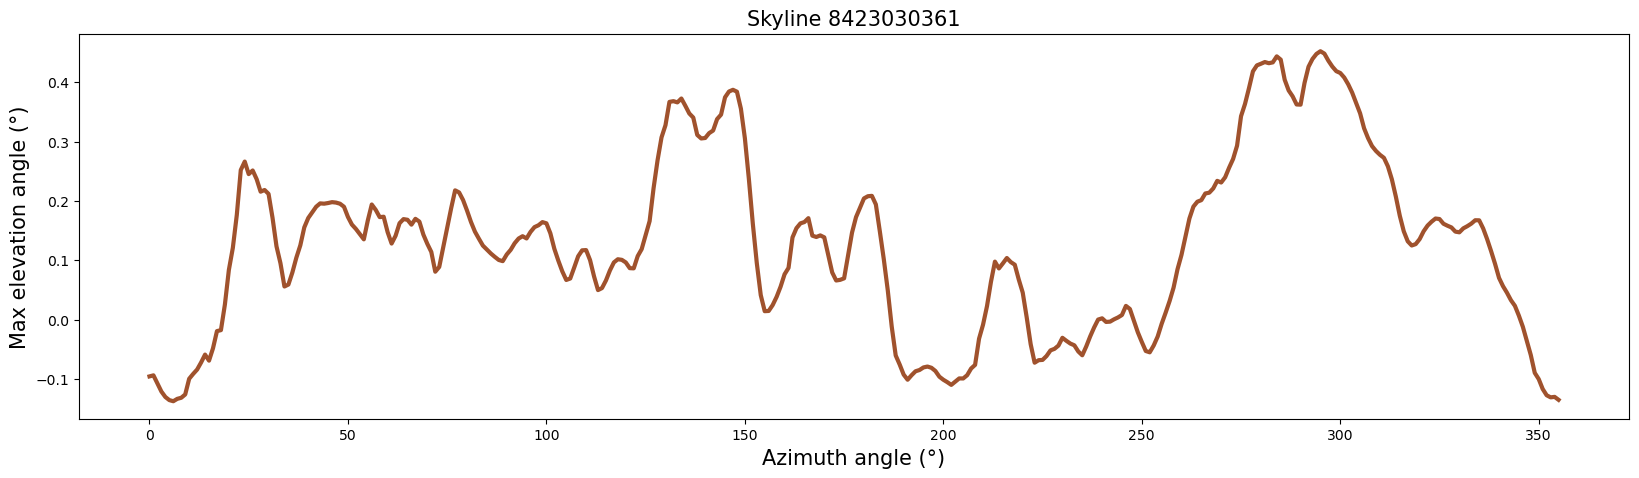

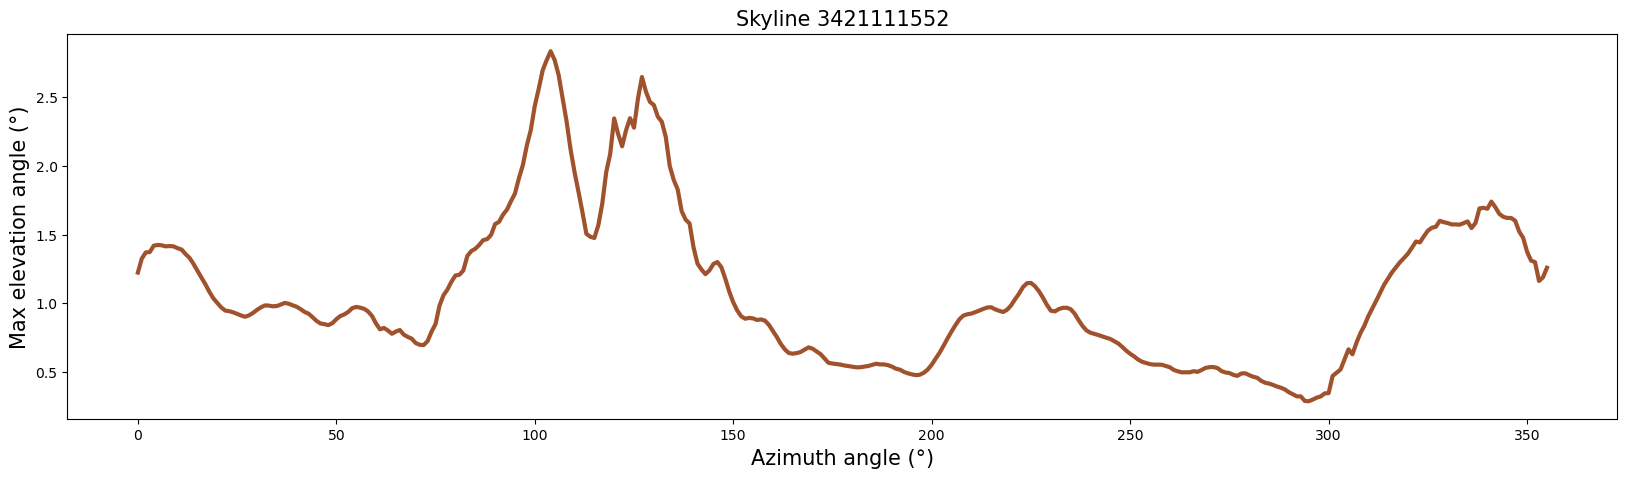

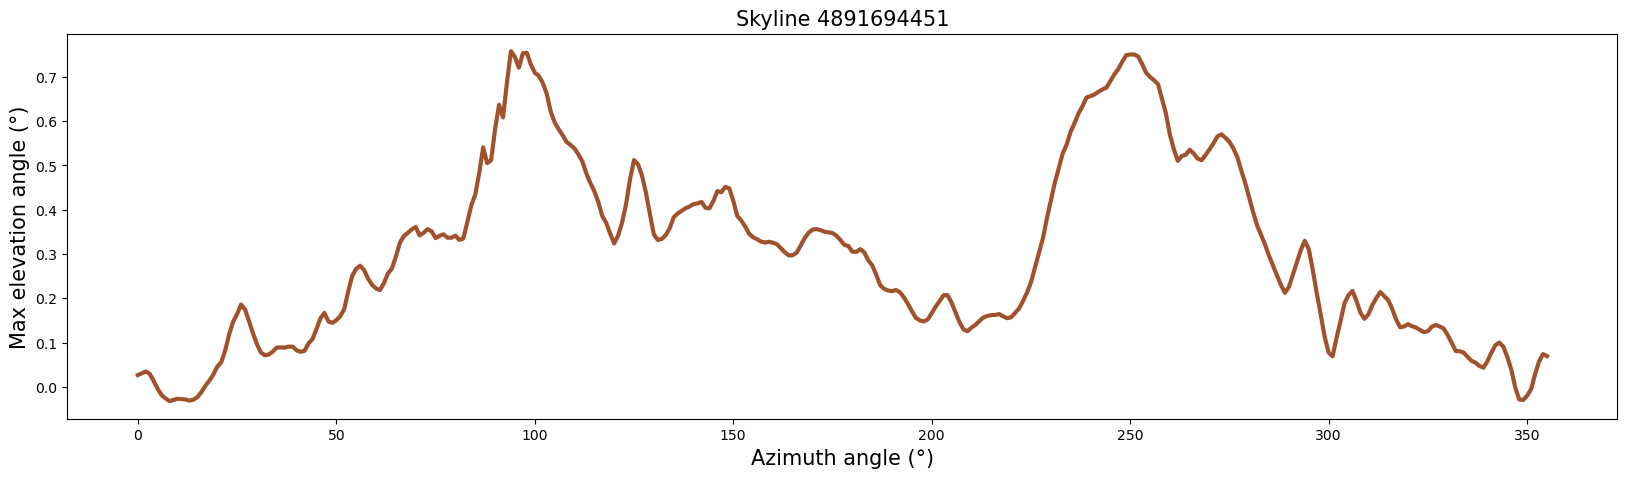

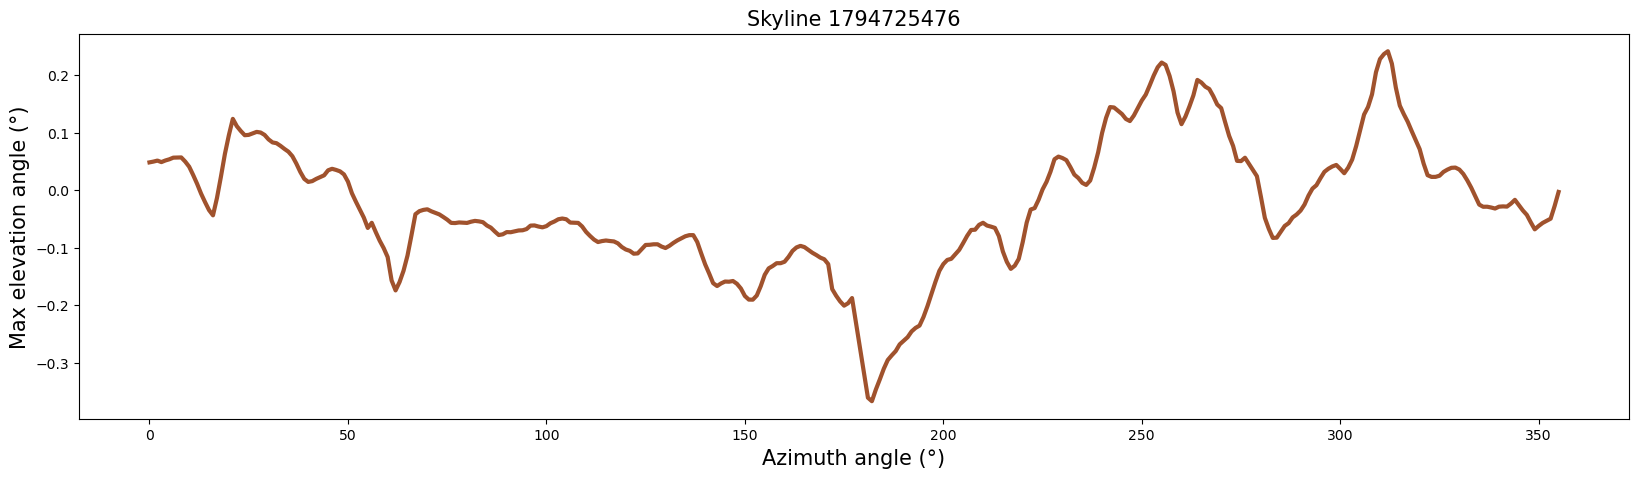

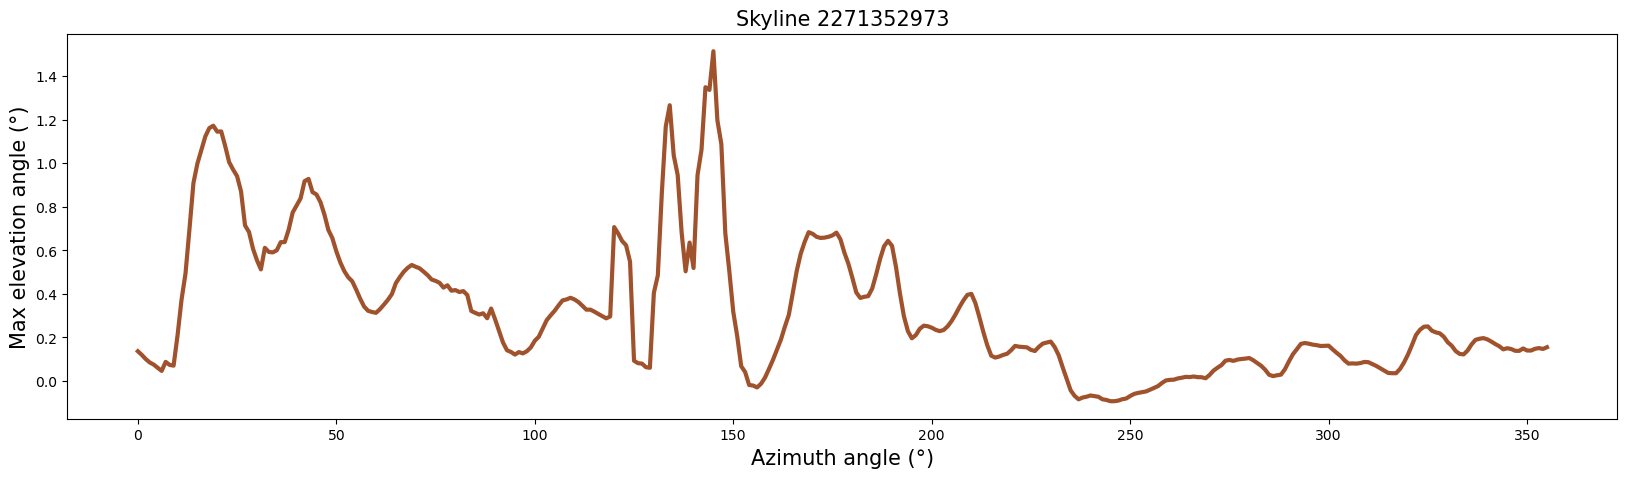

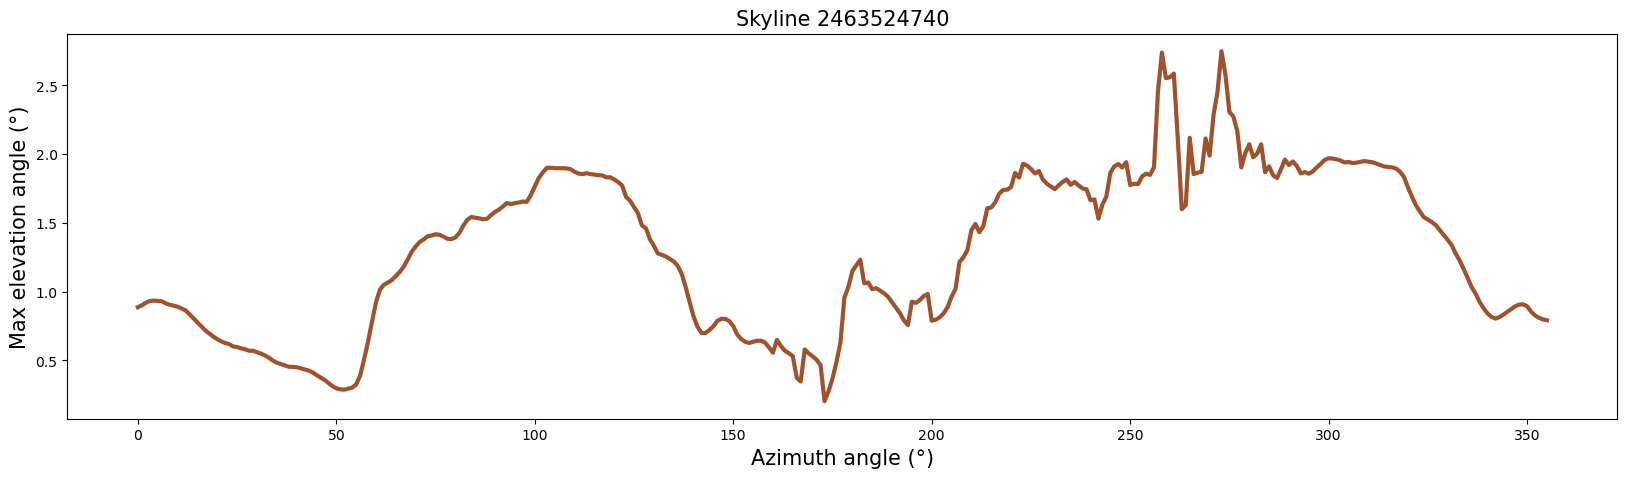

In [62]:
# for each viewpoint
for i, index in enumerate(indexes):
    # get the viewpoint (2D) coordinates and id
    name = str(index)
    view_point = np_viewpoints[i]
    # download and process data if unknown
    if not os.path.exists(horizon_data+name+'.npy'):
        # crop terrain data
        cropped_pc = crop_pc(pc, view_point)
        # get view point altitude
        view_point = get_viewpoint_altitude(cropped_pc, view_point)
        # extract skyline
        spherical = project.array_cartesian_to_spherical(cropped_pc.points, view_point)
        angles = project.get_deg_angles(spherical)
        skyline = project.get_skyline(angles, savepath=horizon_data+name)
    # otherwise, load directly from files
    else:
        skyline = np.load(horizon_data+name+'.npy').astype(float)

    # display skyline
    smooth_skyline = np.convolve(skyline, np.ones(n)/n, mode='valid')
    project.plot_skyline(smooth_skyline, 'Skyline '+name)
